# Title of notebook

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Imports of all used packages and libraries
import os
import glob
import bisect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.signal import butter, filtfilt, hilbert
import matplotlib

In [3]:
from itertools import product

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

In [5]:
from scipy.stats import wilcoxon

In [6]:
from sklearn import preprocessing as pre



In [7]:
import math

In [8]:
from collections import defaultdict

In [9]:
import numpy as np
from astropy.stats import rayleightest
from astropy import units as u


In [10]:
from itertools import product

In [11]:
from collections import Counter
import collections

In [12]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

In [13]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} cells)".format(pct, absolute)

## Inputs & Data

Explanation of each input and where it comes from.

In [14]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [15]:
# GROUPING = "competition_closeness"
GROUPING = "trial_outcome"

In [16]:
MERGED_SPIKE_TRIAL_DF = pd.read_csv("./proc/all_spike_time.csv")

In [17]:
BASIC_LFP_TRACES_DF = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [18]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000
LFP_SAMPLING_RATE=1000
EPHYS_SAMPLING_RATE=20000
TRIAL_DURATION=10

In [19]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [162]:



OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3",
 'win_comp': "#3853a3",
'lose_comp': "#951a1d",
'lose_non_comp': "#e67073",
 'win_non_comp': "#93a5da",
"significant": "#FFAF00",
"not significant": "#800000", 
"multiple conditions": "#15616F",
"competition": "#FFDB91",
                   "win and lose": "#FFDB91"}

# Yellow #FFAF00; teal #15616F

In [21]:
BAND_TO_FREQUENCY = {"theta": {"FREQ": (6,10)}, "gamma": {"FREQ": (30,50)}}
                     # , "beta": {"FREQ": (12,30)}, "gamma": {"FREQ": (30,90)}}

In [22]:
ORDER=4

In [23]:
for key, value in BAND_TO_FREQUENCY.items():
    BAND_TO_FREQUENCY[key]["numerator_b_and_denominator_a"] = butter(ORDER, value["FREQ"], fs=LFP_SAMPLING_RATE, btype='band')

In [24]:
BAND_TO_FREQUENCY

{'theta': {'FREQ': (6, 10),
  'numerator_b_and_denominator_a': (array([ 2.41362231e-08,  0.00000000e+00, -9.65448925e-08,  0.00000000e+00,
           1.44817339e-07,  0.00000000e+00, -9.65448925e-08,  0.00000000e+00,
           2.41362231e-08]),
   array([  1.        ,  -7.92493014,  27.48654927, -54.49518281,
           67.55027592, -53.60770464,  26.59858051,  -7.54402135,
            0.93643324]))},
 'gamma': {'FREQ': (30, 50),
  'numerator_b_and_denominator_a': (array([ 1.32937289e-05,  0.00000000e+00, -5.31749156e-05,  0.00000000e+00,
           7.97623734e-05,  0.00000000e+00, -5.31749156e-05,  0.00000000e+00,
           1.32937289e-05]),
   array([  1.        ,  -7.44539941,  24.47114829, -46.36562494,
           55.3839284 , -42.70740665,  20.76218138,  -5.81872711,
            0.71991033]))}}

In [25]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)

In [26]:
sorted(MERGED_SPIKE_TRIAL_DF["recording_name"].unique())

['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
 '20221215_145401_comp_amd_om_6_1_top_4_base_3',
 '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
 '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
 '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
 '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
 '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
 '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
 '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
 '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged']

In [27]:
sorted(BASIC_LFP_TRACES_DF["recording_file"].unique())

['20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
 '20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
 '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
 '20221215_145401_comp_amd_om_6_1_top_4_base_3',
 '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
 '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
 '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
 '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
 '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
 '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
 '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
 '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

# Functions

In [28]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [29]:
def PPC(spike_phases):
    sp_complex = map(lambda x: [math.cos(x), math.sin(x)], spike_phases)
    all_com = list(itertools.combinations(sp_complex , 2))
    dp_array = np.empty(int(len(spike_phases) * (len(spike_phases) - 1) / 2))
    for d, combination in enumerate(all_com):
        dp = np.dot(combination[0], combination[1])
        dp_array[d] = dp
    dp_sum = np.sum(dp_array)
    ppc = dp_sum / len(dp_array)
    return ppc


In [30]:

def find_closest_nums(list1, list2):
    """
    For each number in list1, find the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of closest numbers from list2 for each number in list1.
    """
    closest_nums = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return it
        if position != len(list2) and list2[position] == num:
            closest_nums.append(num)
        # Else find the closest of the two neighbors
        else:
            if position == 0:
                closest_nums.append(list2[0])
            elif position == len(list2):
                closest_nums.append(list2[-1])
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_nums.append(before if num - before <= after - num else after)

    return closest_nums



In [31]:
def find_closest_indices(list1, list2):
    """
    For each number in list1, find the index of the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of indices of the closest numbers from list2 for each number in list1.
    """
    closest_indices = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return its index
        if position != len(list2) and list2[position] == num:
            closest_indices.append(position)
        # Else find the index of the closest of the two neighbors
        else:
            if position == 0:
                closest_indices.append(0)
            elif position == len(list2):
                closest_indices.append(len(list2) - 1)
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_indices.append(position - 1 if num - before <= after - num else position)

    return closest_indices


In [32]:
def combine_hex_values(d):
  d_items = sorted(d.items())
  tot_weight = sum(d.values())
  red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
  green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
  blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
  zpad = lambda x: x if len(x)==2 else '0' + x
  return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])

# Processing

To help towards deciding how to calculate the phase locking, could you let me know what is the  num of spikes you have per trial condition? The a quick look to make sure that if we make a threshold to exclude low firing we do not end up excluding 50% of the cells. If there is too little spiking then we can focus on social vs alone comparison, and do whole session phase locking

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

## Getting the timestamps

- Getting a list of all the timestamps for LFP and spike for syncing with other data

In [33]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                       vHPC_baseline-trial_lfp_trace  \
0  [-0.07045184, -0.0958607, -0.054282565, 0.1512...   
1  [0.30606127, 0.22405995, 0.28873706, 0.4100066...   
2  [-1.2300198, -1.2323297, -1.3039365, -1.096045...   
3  [0.1605378, 0.4169363, 0.64561605, 0.6756447, ...   
4  [-0.30952612, 0.19056645, 0.4331056, 0.3638087...   

                              BLA_baseline_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                                 BLA_trial_lfp_trace  \
0  [0.31159526, 0.35909453, 0.18239723, -0.509192...   
1  [0.020899683, -0.05129922, 0.113998264, -0.416...   
2  [0.6896895, 1.3983787, 1.7574733, 1.4287783, 1...   
3  [2.6789594, 2.3939636, 2.2096665, 1.97597, 1.8...   
4  [-0.18809713, 0.108298354, -0.66878986, -0.944...   

                        BLA_baseline-trial_lfp_trace  \
0  [2.0367692, 2.1165679, 2.162167, 2.2685654, 2....   
1  [0.30589536, 0.13679792, -0.064599015, -0.3381...   
2  [-2.0025697, -1.9151709, -1.9436705, -1.552276...   
3  [-1.2729807, -1.0468841, -0.8378873, -0.754288...   
4  [-2.1469674, -2.0690687, -2.0937681, -2.152667...   

                               LH_baseline_lfp_trace  \
0  [3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...   
1  [-1.1575702, -1.2699852, -1.3489795, -1.427973...   
2  [-0.20356221, -0.08203254, -0.18837102, -0.142...   
3  [-2.4792056, -2.1480372, -1.8259835, -1.677109...   
4  [-2.1176548, -1.4522797, -1.0360405, -1.108958...   

                                  LH_trial_lfp_trace  \
0  [0.78082824, 1.1788379, 0.8415931, -0.40104795...   
1  [0.91754913, 0.4466216, 0.64410734, 0.03342066...   
2  [-0.58941895, 0.25521234, 0.66233677, 0.416239...   
3  [2.7587237, 2.233108, 1.4796239, 0.93274033, 1...   
4  [0.5104247, 1.4613944, 0.5468836, -0.036458906...   

      

In [34]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF.drop_duplicates(["recording_file", "time", "current_subject"])

In [35]:
BASIC_LFP_TRACES_DF["lfp_trial_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x,x+TRIAL_DURATION*LFP_SAMPLING_RATE))

BASIC_LFP_TRACES_DF["lfp_baseline_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x-TRIAL_DURATION*LFP_SAMPLING_RATE, x))

In [36]:
BASIC_LFP_TRACES_DF["lfp_trial_all_lfp_index"].head()

0    [69541, 69542, 69543, 69544, 69545, 69546, 695...
1    [149541, 149542, 149543, 149544, 149545, 14954...
2    [239541, 239542, 239543, 239544, 239545, 23954...
3    [319541, 319542, 319543, 319544, 319545, 31954...
4    [394541, 394542, 394543, 394544, 394545, 39454...
Name: lfp_trial_all_lfp_index, dtype: object

In [37]:
BASIC_LFP_TRACES_DF["lfp_trial_all_lfp_index"].iloc[0].shape

(10000,)

In [38]:
BASIC_LFP_TRACES_DF["lfp_trial_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x,x+EPHYS_SAMPLING_RATE*TRIAL_DURATION, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

BASIC_LFP_TRACES_DF["lfp_baseline_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x-EPHYS_SAMPLING_RATE*TRIAL_DURATION, x, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

In [39]:
BASIC_LFP_TRACES_DF["lfp_trial_all_ephys_index"].head()

0    [1390826, 1390846, 1390866, 1390886, 1390906, ...
1    [2990825, 2990845, 2990865, 2990885, 2990905, ...
2    [4790823, 4790843, 4790863, 4790883, 4790903, ...
3    [6390821, 6390841, 6390861, 6390881, 6390901, ...
4    [7890820, 7890840, 7890860, 7890880, 7890900, ...
Name: lfp_trial_all_ephys_index, dtype: object

In [40]:
BASIC_LFP_TRACES_DF["lfp_trial_all_ephys_index"].iloc[0].shape

(10000,)

# Syncing LFP and spikes

In [41]:
MERGED_SPIKE_TRIAL_DF.head()

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  1ms_isi  \
0           0              65          937          65           2        1   
1           1             123          998         123           1        1   
2           2             103         1125         103          12        2   
3           3             123         1327         123           1        1   
4           4             103         1346         103          12        2   

   2ms_isi        amp  ch  channel_group  depth        fr group  n_spikes  sh  \
0        3   8.466800   2            0.0   40.0  2.628268  good      9014   0   
1        1  19.984566  24            0.0  480.0  2.384219  good      8177   0   
2       32  14.402934   6            0.0  120.0  8.755451  good     30028   0   
3        1  19.984566  24            0.0  480.0  2.384219  good      8177   0   
4       32  14.402934   6            0.0  120.0  8.755451  good     30028   0   

   si_unit_id                                     recording_name  \
0         8.0  20230618_100636_standard_comp_to_omission_D2_s...   
1        28.0  20230618_100636_standard_comp_to_omission_D2_s...   
2        11.0  20230618_100636_standard_comp_to_omission_D2_s...   
3        28.0  20230618_100636_standard_comp_to_omission_D2_s...   
4        11.0  20230618_100636_standard_comp_to_omission_D2_s...   

   timestamp_isi  current_isi  closest_trial  
0            NaN          NaN       11599246  
1            NaN          NaN       11599246  
2            NaN          NaN       11599246  
3          329.0      0.01645       11599246  
4          221.0      0.01105       11599246

- Getting the ephys sample index from the start of the trial onset
    - i.e. the number of ephys samples that the spike fired compared to sample of the trial onset

In [42]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["spike_times"] - MERGED_SPIKE_TRIAL_DF["closest_trial"]


- Doing the same for LFP, but just downsampling from 20khz to 1khz

In [43]:
(EPHYS_SAMPLING_RATE // LFP_SAMPLING_RATE)

20

In [44]:
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] // (EPHYS_SAMPLING_RATE // LFP_SAMPLING_RATE)

- Removing all spikes that are not during the 10 second trial duration

In [45]:
MERGED_SPIKE_TRIAL_DF = MERGED_SPIKE_TRIAL_DF[np.abs(MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"]) <= TRIAL_DURATION * EPHYS_SAMPLING_RATE].reset_index(drop=True)

- Remaking the spike IDs to include file name
    - This is necessary because some spikes have the same ID number across files because they're just based on ID number that repeats with every spike sorting

In [46]:
MERGED_SPIKE_TRIAL_DF["cluster_id_with_file_name"] = MERGED_SPIKE_TRIAL_DF["cluster_id"].astype(str) + "_" + MERGED_SPIKE_TRIAL_DF["recording_name"]

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [47]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                               LH_baseline_lfp_trace  \
0  [3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...   
1  [-1.1575702, -1.2699852, -1.3489795, -1.427973...   
2  [-0.20356221, -0.08203254, -0.18837102, -0.142...   
3  [-2.4792056, -2.1480372, -1.8259835, -1.677109...   
4  [-2.1176548, -1.4522797, -1.0360405, -1.108958...   

                                  LH_trial_lfp_trace  \
0  [0.78082824, 1.1788379, 0.8415931, -0.40104795...   
1  [0.91754913, 0.4466216, 0.64410734, 0.03342066...   
2  [-0.58941895, 0.25521234, 0.66233677, 0.416239...   
3  [2.7587237, 2.233108, 1.4796239, 0.93274033, 1...   
4  [0.5104247, 1.4613944, 0.5468836, -0.036458906...   

                         LH_baseline-trial_lfp_trace  \
0  [3.0443187, 3.1354659, 3.1810396, 3.1901543, 3...   
1  [-1.1575702, -1.2699852, -1.3489795, -1.427973...   
2  [-0.20356221, -0.08203254, -0.18837102, -0.142...   
3  [-2.4792056, -2.1480372, -1.8259835, -1.677109...   
4  [-2.1176548, -1.4522797, -1.0360405, -1.108958...   

                               MD_baseline_lfp_trace  \
0  [1.3860394, 1.4873364, 1.7566382, 1.8208753, 1...   
1  [-0.15318082, -0.16800477, 0.019765267, 0.1605...   
2  [-0.32859758, -0.5361329, -0.97591007, -0.7609...   
3  [-2.7720788, -2.5620728, -2.3125362, -2.062999...   
4  [-2.018528, -1.7220489, -1.4329818, -1.3736861...   

                                  MD_trial_lfp_trace  \
0  [-0.9857927, -0.8746131, -0.7362562, -1.413216...   
1  [1.620752, 1.3415675, 1.4601592, 0.94132084, -...   
2  [0.088943705, 0.8770837, 1.2056813, 0.88696635...   
3  [2.0802944, 1.7344022, 1.1192082, 0.4521305, 0...   
4  [0.31130296, 1.0006167, 0.25200716, -0.2347125...   

                         MD_baseline-trial_lfp_trace  \
0  [1.3860394, 1.4873364, 1.7566382, 1.8208753, 1...   
1  [-0.15318082, -0.16800477, 0.019765267, 0.1605...   
2  [-0.32859758, -0.5361329, -0.97591007, -0.7609...   
3  [-2.7720788, -2.5620728, -2.3125362, -2.062999...   
4  [-2.018528, -1.7220489, -1.4329818, -1.3736861...   

      

# Phase calculation

- Calculating the phase in degrees and radians

In [48]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trial_lfp_trace" in col and "baseline" not in col]

In [49]:
trace_columns

['mPFC_trial_lfp_trace',
 'vHPC_trial_lfp_trace',
 'BLA_trial_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_trial_lfp_trace']

In [50]:
for trace_col, (band, value) in product(trace_columns, BAND_TO_FREQUENCY.items()):
    region_name = "_".join(trace_col.split("_")[:2])
    print(band, region_name)
    BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)] = BASIC_LFP_TRACES_DF[trace_col].apply(lambda x: filtfilt(value["numerator_b_and_denominator_a"][0], value["numerator_b_and_denominator_a"][1], x, padtype=None))
    
    BASIC_LFP_TRACES_DF["{}_{}_phase_radians".format(band, region_name)] = BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))

    BASIC_LFP_TRACES_DF["{}_{}_phase_degrees".format(band, region_name)] = BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)].apply(lambda x: np.angle(hilbert(x), deg=True))

theta mPFC_trial
gamma mPFC_trial
theta vHPC_trial
gamma vHPC_trial
theta BLA_trial
gamma BLA_trial
theta LH_trial
gamma LH_trial
theta MD_trial
gamma MD_trial


In [51]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                        theta_LH_trial_phase_degrees  \
0  [-177.480368000256, -136.70034736957496, -129....   
1  [23.885907375143606, 57.73762248780535, 65.429...   
2  [-46.22893566981424, -20.553855916077566, -18....   
3  [-39.08333030984333, -6.3376332508563005, -3.7...   
4  [177.0245481522089, -140.82873215501508, -134....   

                             gamma_LH_trial_filtered  \
0  [0.04448402955526287, 0.04362940897482218, 0.0...   
1  [0.04833293362125646, 0.038251223146059866, 0....   
2  [0.014748319957295808, 0.03654785861724517, 0....   
3  [-0.08901737191591974, -0.1321286714659348, -0...   
4  [-0.07728410155530424, -0.032274698697822984, ...   

                        gamma_LH_trial_phase_radians  \
0  [-0.4570005840022114, 0.306957592315969, 0.517...   
1  [-0.4293930050395771, 0.43390257886684797, 0.5...   
2  [-1.2350345276954808, -0.8534907679879358, -0....   
3  [2.118348008541516, 2.478696869576655, 2.70182...   
4  [-2.6894822015720563, -1.8251011601980278, -1....   

                        gamma_LH_trial_phase_degrees  \
0  [-26.18420469834056, 17.58737452920237, 29.640...   
1  [-24.602406941207455, 24.860786488912733, 34.2...   
2  [-70.76226598988403, -48.90141885908807, -29.8...   
3  [121.37240042937174, 142.01886931903138, 154.8...   
4  [-154.09597922563177, -104.57059366377695, -83...   

                             theta_MD_trial_filtered  \
0  [-0.31933232977218706, -0.3042444291930399, -0...   
1  [0.03776166857825633, 0.02073825388674073, 0.0...   
2  [0.3245165618328705, 0.3224921204458333, 0.319...   
3  [0.22782687262288293, 0.22944604511486946, 0.2...   
4  [-0.07327103410608538, -0.05365174581749345, -...   

                        theta_MD_trial_phase_radians  \
0  [2.6074698164188383, -3.0043733528633907, -2.9...   
1  [1.2902210370755445, 1.4537311398611497, 1.551...   
2  [-0.7759787843286456, -0.297593379146859, -0.2...   
3  [-0.9234279252629556, -0.5889370269532941, -0....   
4  [-2.101860654563031, -1.8361762775148904, -1.7...   

      

- Plotting an example filtered trace

In [52]:
MERGED_SPIKE_TRIAL_DF.head()

Unnamed: 0  spike_clusters  spike_times  cluster_id  1_5_ms_isi  1ms_isi  \
0       20759             103     11399273         103          12        2   
1       20760              83     11399416          83           9        3   
2       20761              65     11399798          65           2        1   
3       20762             103     11399996         103          12        2   
4       20763             103     11400706         103          12        2   

   2ms_isi        amp  ch  channel_group  ...  n_spikes  sh si_unit_id  \
0       32  14.402934   6            0.0  ...     30028   0       11.0   
1       26  13.022879   2            0.0  ...     36640   0        5.0   
2        3   8.466800   2            0.0  ...      9014   0        8.0   
3       32  14.402934   6            0.0  ...     30028   0       11.0   
4       32  14.402934   6            0.0  ...     30028   0       11.0   

                                      recording_name  timestamp_isi  \
0  20230618_100636_standard_comp_to_omission_D2_s...          183.0   
1  20230618_100636_standard_comp_to_omission_D2_s...         1165.0   
2  20230618_100636_standard_comp_to_omission_D2_s...         7188.0   
3  20230618_100636_standard_comp_to_omission_D2_s...          723.0   
4  20230618_100636_standard_comp_to_omission_D2_s...          710.0   

   current_isi closest_trial  ephys_sample_from_trial_onset  \
0      0.00915      11599246                        -199973   
1      0.05825      11599246                        -199830   
2      0.35940      11599246                        -199448   
3      0.03615      11599246                        -199250   
4      0.03550      11599246                        -198540   

   lfp_sample_from_trial_onset  \
0                        -9999   
1                        -9992   
2                        -9973   
3                        -9963   
4                        -9927   

                           cluster_id_with_file_name  
0  103_20230618_100636_standard_comp_to_omission_...  
1  83_20230618_100636_standard_comp_to_omission_D...  
2  65_20230618_100636_standard_comp_to_omission_D...  
3  103_20230618_100636_standard_comp_to_omission_...  
4  103_20230618_100636_standard_comp_to_omission_...  

[5 rows x 23 columns]

In [53]:
example_index = 5

In [54]:
exampled_xlim = 2000

(0.0, 2000.0)

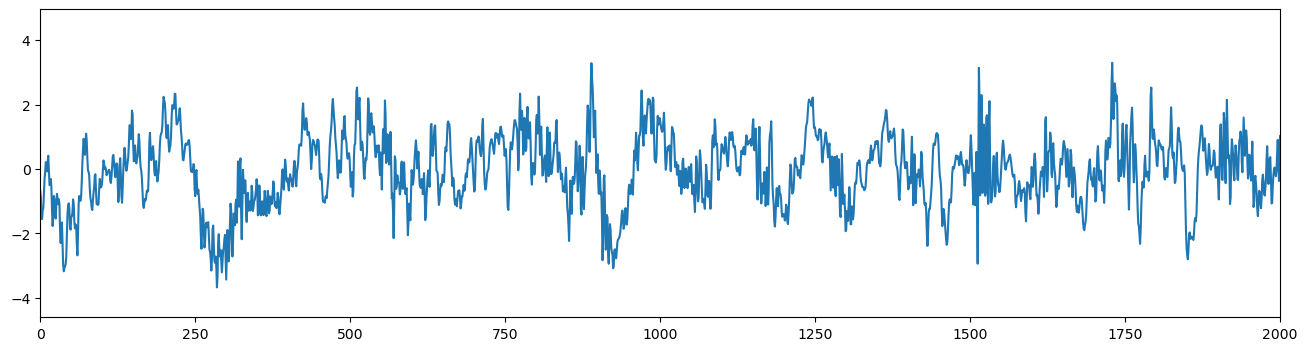

In [55]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_lfp_trace"].iloc[example_index])

plt.xlim(0,exampled_xlim)

(0.0, 2000.0)

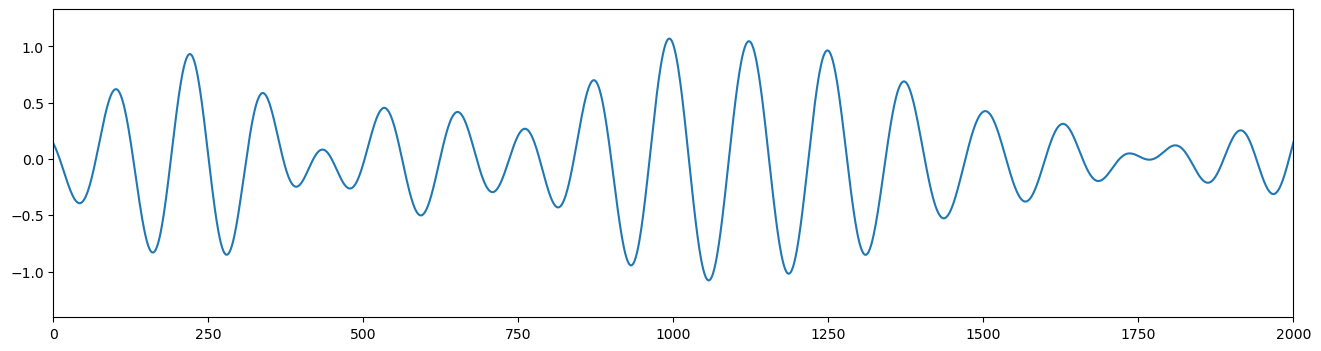

In [56]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_filtered"].iloc[example_index])

plt.xlim(0,exampled_xlim)

(0.0, 2000.0)

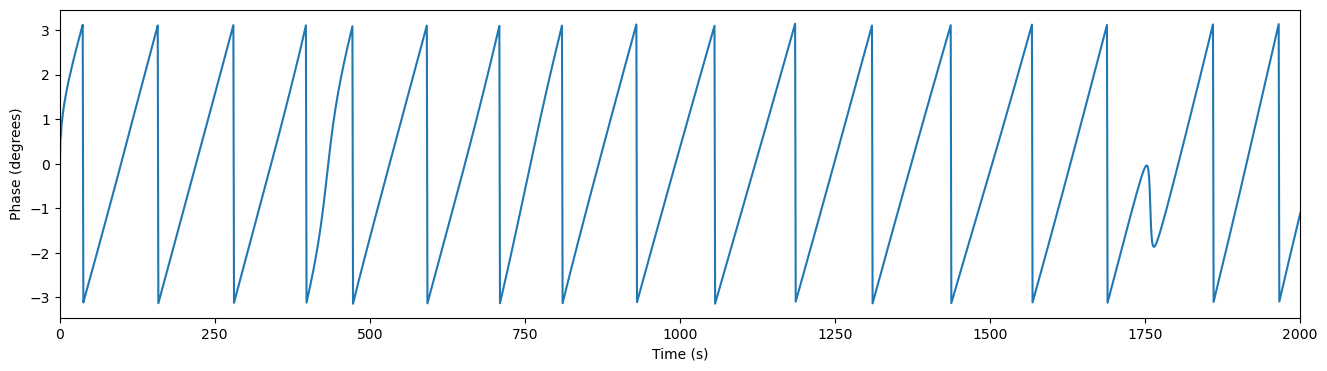

In [57]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_phase_radians"].iloc[example_index])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

plt.xlim(0,exampled_xlim)

(0.0, 2000.0)

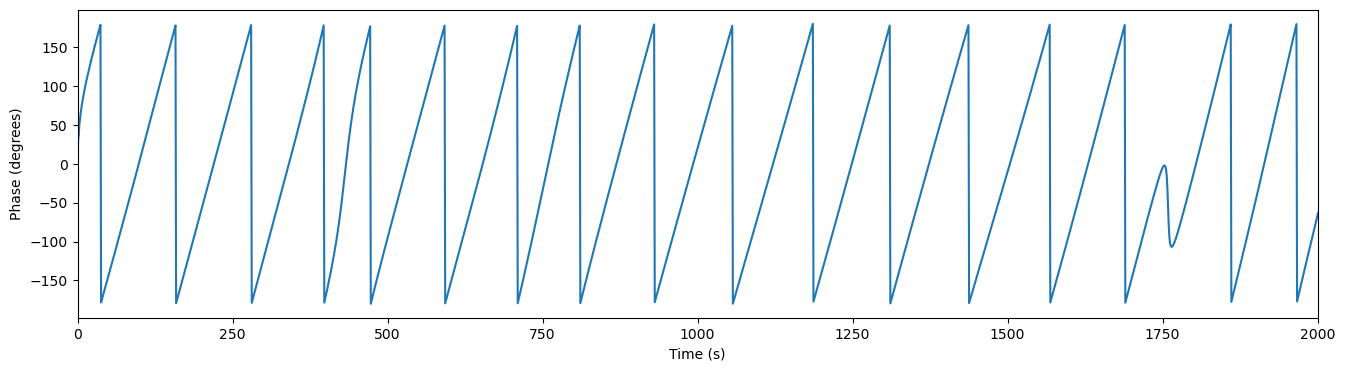

In [58]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_phase_degrees"].iloc[example_index])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

plt.xlim(0,exampled_xlim)

In [59]:
BASIC_LFP_TRACES_DF.head()

time                                      recording_dir  \
0   6310663  20221202_134600_omission_and_competition_subje...   
1   7910662  20221202_134600_omission_and_competition_subje...   
2   9710660  20221202_134600_omission_and_competition_subje...   
3  11310658  20221202_134600_omission_and_competition_subje...   
4  12810657  20221202_134600_omission_and_competition_subje...   

                                      recording_file  time_stamp_index  \
0  20221202_134600_omission_and_competition_subje...           1390826   
1  20221202_134600_omission_and_competition_subje...           2990825   
2  20221202_134600_omission_and_competition_subje...           4790823   
3  20221202_134600_omission_and_competition_subje...           6390821   
4  20221202_134600_omission_and_competition_subje...           7890820   

                                          video_file  video_frame  \
0  20221202_134600_omission_and_competition_subje...         1734   
1  20221202_134600_omission_and_competition_subje...         3728   
2  20221202_134600_omission_and_competition_subje...         5972   
3  20221202_134600_omission_and_competition_subje...         7966   
4  20221202_134600_omission_and_competition_subje...         9836   

   video_number      subject_info competition_closeness  \
0           1.0  6_1_top_2_base_3              rewarded   
1           1.0  6_1_top_2_base_3              rewarded   
2           1.0  6_1_top_2_base_3              rewarded   
3           1.0  6_1_top_2_base_3              omission   
4           1.0  6_1_top_2_base_3              rewarded   

                                          video_name  ...  \
0  20221202_134600_omission_and_competition_subje...  ...   
1  20221202_134600_omission_and_competition_subje...  ...   
2  20221202_134600_omission_and_competition_subje...  ...   
3  20221202_134600_omission_and_competition_subje...  ...   
4  20221202_134600_omission_and_competition_subje...  ...   

                        theta_LH_trial_phase_degrees  \
0  [-177.480368000256, -136.70034736957496, -129....   
1  [23.885907375143606, 57.73762248780535, 65.429...   
2  [-46.22893566981424, -20.553855916077566, -18....   
3  [-39.08333030984333, -6.3376332508563005, -3.7...   
4  [177.0245481522089, -140.82873215501508, -134....   

                             gamma_LH_trial_filtered  \
0  [0.04448402955526287, 0.04362940897482218, 0.0...   
1  [0.04833293362125646, 0.038251223146059866, 0....   
2  [0.014748319957295808, 0.03654785861724517, 0....   
3  [-0.08901737191591974, -0.1321286714659348, -0...   
4  [-0.07728410155530424, -0.032274698697822984, ...   

                        gamma_LH_trial_phase_radians  \
0  [-0.4570005840022114, 0.306957592315969, 0.517...   
1  [-0.4293930050395771, 0.43390257886684797, 0.5...   
2  [-1.2350345276954808, -0.8534907679879358, -0....   
3  [2.118348008541516, 2.478696869576655, 2.70182...   
4  [-2.6894822015720563, -1.8251011601980278, -1....   

                        gamma_LH_trial_phase_degrees  \
0  [-26.18420469834056, 17.58737452920237, 29.640...   
1  [-24.602406941207455, 24.860786488912733, 34.2...   
2  [-70.76226598988403, -48.90141885908807, -29.8...   
3  [121.37240042937174, 142.01886931903138, 154.8...   
4  [-154.09597922563177, -104.57059366377695, -83...   

                             theta_MD_trial_filtered  \
0  [-0.31933232977218706, -0.3042444291930399, -0...   
1  [0.03776166857825633, 0.02073825388674073, 0.0...   
2  [0.3245165618328705, 0.3224921204458333, 0.319...   
3  [0.22782687262288293, 0.22944604511486946, 0.2...   
4  [-0.07327103410608538, -0.05365174581749345, -...   

                        theta_MD_trial_phase_radians  \
0  [2.6074698164188383, -3.0043733528633907, -2.9...   
1  [1.2902210370755445, 1.4537311398611497, 1.551...   
2  [-0.7759787843286456, -0.297593379146859, -0.2...   
3  [-0.9234279252629556, -0.5889370269532941, -0....   
4  [-2.101860654563031, -1.8361762775148904, -1.7...   

      

- Combining all the LFP phases with the spike firing times

In [60]:
TRACE_AND_SPIKE_DF = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [61]:
TRACE_AND_SPIKE_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'mPFC_baseline_lfp_trace', 'mPFC_trial_lfp_trace',
       'mPFC_baseline-trial_lfp_trace', 'vHPC_baseline_lfp_trace',
       'vHPC_trial_lfp_trace', 'vHPC_baseline-trial_lfp_trace',
       'BLA_baseline_lfp_trace', 'BLA_trial_lfp_trace',
       'BLA_baseline-trial_lfp_trace', 'LH_baseline_lfp_trace',
       'LH_trial_lfp_trace', 'LH_baseline-trial_lfp_trace',
       'MD_baseline_lfp_trace', 'MD_trial_lfp_trace',
       'MD_baseline-trial_lfp_trace', 'lfp_trial_all_lfp_index',
       'lfp_baseline_all_lfp

- Getting the phase of all the spikes for each neuron

In [62]:
TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"]

0        -9953
1        -9851
2        -9818
3        -9768
4        -9737
          ... 
292060    9895
292061    9912
292062    9924
292063    9936
292064    9944
Name: lfp_sample_from_trial_onset, Length: 292065, dtype: int64

In [63]:
radian_phase_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trial_phase_radians" in col and "baseline" not in col]

In [64]:
degree_phase_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trial_phase_degrees" in col and "baseline" not in col]

In [65]:
degree_phase_columns

['theta_mPFC_trial_phase_degrees',
 'gamma_mPFC_trial_phase_degrees',
 'theta_vHPC_trial_phase_degrees',
 'gamma_vHPC_trial_phase_degrees',
 'theta_BLA_trial_phase_degrees',
 'gamma_BLA_trial_phase_degrees',
 'theta_LH_trial_phase_degrees',
 'gamma_LH_trial_phase_degrees',
 'theta_MD_trial_phase_degrees',
 'gamma_MD_trial_phase_degrees']

In [66]:
for col in radian_phase_columns:
    region_name = "_".join(col.split("_")[:3])
    print(region_name)
    TRACE_AND_SPIKE_DF["{}_spike_phase_radians".format(region_name)] = TRACE_AND_SPIKE_DF.apply(lambda x: x[col][x["lfp_sample_from_trial_onset"]], axis=1)

theta_mPFC_trial
gamma_mPFC_trial
theta_vHPC_trial
gamma_vHPC_trial
theta_BLA_trial
gamma_BLA_trial
theta_LH_trial
gamma_LH_trial
theta_MD_trial
gamma_MD_trial


In [67]:
for col in degree_phase_columns:
    region_name = "_".join(col.split("_")[:3])
    print(region_name)
    TRACE_AND_SPIKE_DF["{}_spike_phase_degrees".format(region_name)] = TRACE_AND_SPIKE_DF.apply(lambda x: x[col][x["lfp_sample_from_trial_onset"]], axis=1)

theta_mPFC_trial
gamma_mPFC_trial
theta_vHPC_trial
gamma_vHPC_trial
theta_BLA_trial
gamma_BLA_trial
theta_LH_trial
gamma_LH_trial
theta_MD_trial
gamma_MD_trial


In [68]:
TRACE_AND_SPIKE_DF.head()

time                            recording_dir  \
0  4359951  20221214_125409_om_and_comp_6_1_and_6_3   
1  4359951  20221214_125409_om_and_comp_6_1_and_6_3   
2  4359951  20221214_125409_om_and_comp_6_1_and_6_3   
3  4359951  20221214_125409_om_and_comp_6_1_and_6_3   
4  4359951  20221214_125409_om_and_comp_6_1_and_6_3   

                                      recording_file  time_stamp_index  \
0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   
1  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   
2  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   
3  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   
4  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   

                                          video_file  video_frame  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   
1  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   
2  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   
3  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   
4  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   

   video_number             subject_info competition_closeness  \
0           1.0  6_1_top_1_base_2_vs_6_3              rewarded   
1           1.0  6_1_top_1_base_2_vs_6_3              rewarded   
2           1.0  6_1_top_1_base_2_vs_6_3              rewarded   
3           1.0  6_1_top_1_base_2_vs_6_3              rewarded   
4           1.0  6_1_top_1_base_2_vs_6_3              rewarded   

                                  video_name  ...  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   

  theta_mPFC_trial_spike_phase_degrees gamma_mPFC_trial_spike_phase_degrees  \
0                            32.445000                           160.737398   
1                           -93.715245                           -60.235725   
2                           -23.193589                           111.005108   
3                            93.715662                             8.448121   
4                           174.064202                           135.893730   

  theta_vHPC_trial_spike_phase_degrees  gamma_vHPC_trial_spike_phase_degrees  \
0                            85.926316                           -106.071628   
1                            25.553365                            -20.713141   
2                           120.388955                             90.852535   
3                           -93.153295                            -50.302006   
4                            -0.467570                             92.625957   

  theta_BLA_trial_spike_phase_degrees gamma_BLA_trial_spike_phase_degrees  \
0                           38.395991                          105.725894   
1                          -78.879341                          -18.162913   
2                           -7.926099                          165.413669   
3                          100.153026                          175.805953   
4                          175.902814                         -161.326933   

  theta_LH_trial_spike_phase_degrees gamma_LH_trial_spike_phase_degrees  \
0                         -17.382064                         131.867080   
1                        -118.032660                         -29.201783   
2                         -32.282413                        -107.714686   
3                          98.255972                        -151.838337   
4                        -176.662062                         157.055189   

  theta_MD_trial_spike_phase_degrees gamma_MD_trial_spike_phase_degrees  
0                         -13.374189                         110.432768  
1                        -102.023385                         -39.303967  
2      

In [69]:
TRACE_AND_SPIKE_DF["recording_file"].unique()

array(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

In [70]:
radians_spike_columns = sorted([col for col in TRACE_AND_SPIKE_DF.columns if "trial_spike_phase_radians" in col])
degrees_spike_columns = sorted([col for col in TRACE_AND_SPIKE_DF.columns if "trial_spike_phase_degrees" in col])

In [71]:
radians_spike_columns

['gamma_BLA_trial_spike_phase_radians',
 'gamma_LH_trial_spike_phase_radians',
 'gamma_MD_trial_spike_phase_radians',
 'gamma_mPFC_trial_spike_phase_radians',
 'gamma_vHPC_trial_spike_phase_radians',
 'theta_BLA_trial_spike_phase_radians',
 'theta_LH_trial_spike_phase_radians',
 'theta_MD_trial_spike_phase_radians',
 'theta_mPFC_trial_spike_phase_radians',
 'theta_vHPC_trial_spike_phase_radians']

In [72]:
degrees_spike_columns

['gamma_BLA_trial_spike_phase_degrees',
 'gamma_LH_trial_spike_phase_degrees',
 'gamma_MD_trial_spike_phase_degrees',
 'gamma_mPFC_trial_spike_phase_degrees',
 'gamma_vHPC_trial_spike_phase_degrees',
 'theta_BLA_trial_spike_phase_degrees',
 'theta_LH_trial_spike_phase_degrees',
 'theta_MD_trial_spike_phase_degrees',
 'theta_mPFC_trial_spike_phase_degrees',
 'theta_vHPC_trial_spike_phase_degrees']

## Filtering for neurons that have enough spikes

- Getting rows that focus on the trial portion only

In [73]:
TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"]

0        -9953
1        -9851
2        -9818
3        -9768
4        -9737
          ... 
292060    9895
292061    9912
292062    9924
292063    9936
292064    9944
Name: lfp_sample_from_trial_onset, Length: 292065, dtype: int64

In [74]:
temp_df = TRACE_AND_SPIKE_DF.copy()

In [75]:
TRACE_AND_SPIKE_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name',
       ...
       'theta_mPFC_trial_spike_phase_degrees',
       'gamma_mPFC_trial_spike_phase_degrees',
       'theta_vHPC_trial_spike_phase_degrees',
       'gamma_vHPC_trial_spike_phase_degrees',
       'theta_BLA_trial_spike_phase_degrees',
       'gamma_BLA_trial_spike_phase_degrees',
       'theta_LH_trial_spike_phase_degrees',
       'gamma_LH_trial_spike_phase_degrees',
       'theta_MD_trial_spike_phase_degrees',
       'gamma_MD_trial_spike_phase_degrees'],
      dtype='object', length=114)

- Getting the total number of spikes for each neuron and each trial type

In [76]:
temp_df = temp_df.groupby([GROUPING, "cluster_id_with_file_name"]).count()["recording_dir"].reset_index()

In [77]:
temp_df[temp_df["recording_dir"] >= 1].groupby([GROUPING]).count()

cluster_id_with_file_name  recording_dir
trial_outcome                                          
lose                                 154            154
omission                             106            106
rewarded                             124            124
win                                  118            118

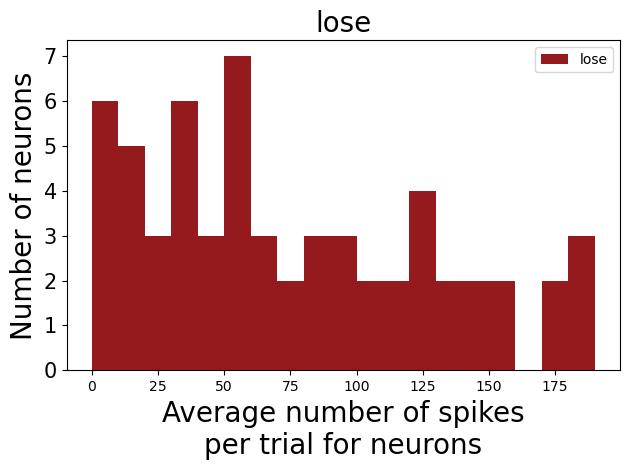

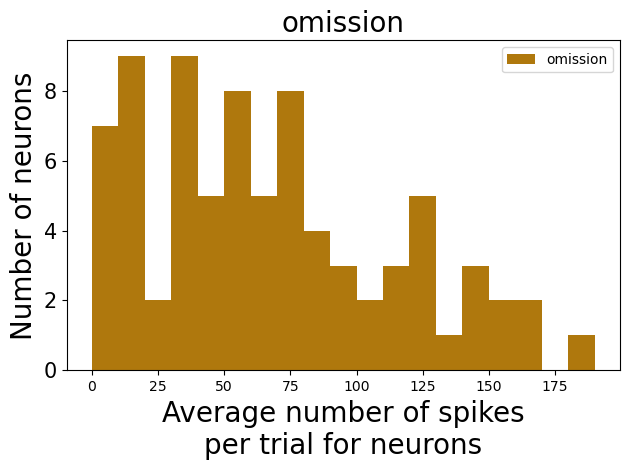

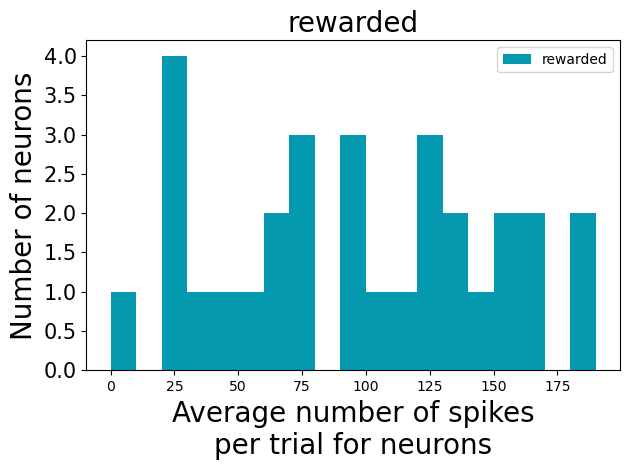

In [78]:
for outcome in temp_df[GROUPING].unique():
    fig, ax = plt.subplots()
    plt.hist(temp_df[temp_df[GROUPING] == outcome]["recording_dir"], color=OUTCOME_TO_COLOR[outcome], label=outcome, bins=range(0, 200, 10))
    plt.legend()
    # plt.ylim(0,10)
    # plt.xlim(0, 200)
    # plt.xticks(np.arange(0, 200, 10), rotation=90, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(outcome, fontsize=20)
    plt.xlabel("Average number of spikes\nper trial for neurons", fontsize=20)
    plt.ylabel("Number of neurons", fontsize=20)
    plt.tight_layout()
    plt.savefig("./proc/per_trial_spike_histogram_{}.png".format(outcome))
    
    plt.show()

In [79]:
len(temp_df["cluster_id_with_file_name"].unique())

171

In [80]:
temp_df

trial_outcome                          cluster_id_with_file_name  \
0            lose  100_20230617_115521_standard_comp_to_omission_...   
1            lose  100_20230620_114347_standard_comp_to_omission_...   
2            lose  103_20230618_100636_standard_comp_to_omission_...   
3            lose  105_20230617_115521_standard_comp_to_omission_...   
4            lose  105_20230618_100636_standard_comp_to_omission_...   
..            ...                                                ...   
497           win  95_20230617_115521_standard_comp_to_omission_D...   
498           win  98_20230618_100636_standard_comp_to_omission_D...   
499           win  98_20230620_114347_standard_comp_to_omission_D...   
500           win  99_20230618_100636_standard_comp_to_omission_D...   
501           win  9_20230618_100636_standard_comp_to_omission_D2...   

     recording_dir  
0              104  
1               16  
2             1279  
3              243  
4              196  
..             ...  
497             47  
498             23  
499            558  
500            155  
501            106  

[502 rows x 3 columns]

In [81]:
temp_df = temp_df[temp_df["recording_dir"] >= 1].groupby("cluster_id_with_file_name").count()

In [82]:
temp_df

trial_outcome  \
cluster_id_with_file_name                                           
100_20230617_115521_standard_comp_to_omission_D...              2   
100_20230620_114347_standard_comp_to_omission_D...              4   
103_20230618_100636_standard_comp_to_omission_D...              4   
105_20230617_115521_standard_comp_to_omission_D...              2   
105_20230618_100636_standard_comp_to_omission_D...              4   
...                                                           ...   
95_20230617_115521_standard_comp_to_omission_D1...              2   
98_20230618_100636_standard_comp_to_omission_D2...              4   
98_20230620_114347_standard_comp_to_omission_D4...              4   
99_20230618_100636_standard_comp_to_omission_D2...              4   
9_20230618_100636_standard_comp_to_omission_D2_...              4   

                                                    recording_dir  
cluster_id_with_file_name                                          
100_20230617_115521_standard_comp_to_omission_D...              2  
100_20230620_114347_standard_comp_to_omission_D...              4  
103_20230618_100636_standard_comp_to_omission_D...              4  
105_20230617_115521_standard_comp_to_omission_D...              2  
105_20230618_100636_standard_comp_to_omission_D...              4  
...                                                           ...  
95_20230617_115521_standard_comp_to_omission_D1...              2  
98_20230618_100636_standard_comp_to_omission_D2...              4  
98_20230620_114347_standard_comp_to_omission_D4...              4  
99_20230618_100636_standard_comp_to_omission_D2...              4  
9_20230618_100636_standard_comp_to_omission_D2_...              4  

[171 rows x 2 columns]

In [83]:
high_spike_neurons = temp_df[temp_df[GROUPING] >= 4].reset_index()["cluster_id_with_file_name"]

In [84]:
high_spike_neurons

0     100_20230620_114347_standard_comp_to_omission_...
1     103_20230618_100636_standard_comp_to_omission_...
2     105_20230618_100636_standard_comp_to_omission_...
3     106_20230618_100636_standard_comp_to_omission_...
4     118_20230618_100636_standard_comp_to_omission_...
                            ...                        
66    93_20230618_100636_standard_comp_to_omission_D...
67    98_20230618_100636_standard_comp_to_omission_D...
68    98_20230620_114347_standard_comp_to_omission_D...
69    99_20230618_100636_standard_comp_to_omission_D...
70    9_20230618_100636_standard_comp_to_omission_D2...
Name: cluster_id_with_file_name, Length: 71, dtype: object

## Getting the average number of spikes per trial

In [85]:
temp_df = TRACE_AND_SPIKE_DF[TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"] >= 1].copy()

In [86]:
temp_df = temp_df.groupby([GROUPING, "cluster_id_with_file_name", "time"]).count().reset_index()

In [87]:
temp_df.groupby([GROUPING, "cluster_id_with_file_name"])["recording_dir"].mean()

trial_outcome  cluster_id_with_file_name                                                   
lose           100_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged       3.571429
               100_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged      4.000000
               103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged     130.000000
               105_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged       8.357143
               105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged      16.750000
                                                                                                  ...    
win            95_20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged       25.000000
               98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged        1.333333
               98_20230620_114347_standard_comp_to_omission_

In [88]:
BACK_UP_TRACE_AND_SPIKE_DF = TRACE_AND_SPIKE_DF.copy()

# Filtering for all neurons that have spikes in all trial types

In [89]:
TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"]

0        -9953
1        -9851
2        -9818
3        -9768
4        -9737
          ... 
292060    9895
292061    9912
292062    9924
292063    9936
292064    9944
Name: lfp_sample_from_trial_onset, Length: 292065, dtype: int64

In [90]:
# TRACE_AND_SPIKE_DF = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"]).isin(high_spike_neurons)]

In [91]:
TRACE_AND_SPIKE_DF.head()

time                            recording_dir  \
0  4359951  20221214_125409_om_and_comp_6_1_and_6_3   
1  4359951  20221214_125409_om_and_comp_6_1_and_6_3   
2  4359951  20221214_125409_om_and_comp_6_1_and_6_3   
3  4359951  20221214_125409_om_and_comp_6_1_and_6_3   
4  4359951  20221214_125409_om_and_comp_6_1_and_6_3   

                                      recording_file  time_stamp_index  \
0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   
1  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   
2  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   
3  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   
4  20221214_125409_om_and_comp_6_1_top_1_base_2_v...           1408048   

                                          video_file  video_frame  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   
1  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   
2  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   
3  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   
4  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...         1405   

   video_number             subject_info competition_closeness  \
0           1.0  6_1_top_1_base_2_vs_6_3              rewarded   
1           1.0  6_1_top_1_base_2_vs_6_3              rewarded   
2           1.0  6_1_top_1_base_2_vs_6_3              rewarded   
3           1.0  6_1_top_1_base_2_vs_6_3              rewarded   
4           1.0  6_1_top_1_base_2_vs_6_3              rewarded   

                                  video_name  ...  \
0  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
1  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
2  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
3  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   
4  20221214_125409_om_and_comp_6_1_and_6_3.1  ...   

  theta_mPFC_trial_spike_phase_degrees gamma_mPFC_trial_spike_phase_degrees  \
0                            32.445000                           160.737398   
1                           -93.715245                           -60.235725   
2                           -23.193589                           111.005108   
3                            93.715662                             8.448121   
4                           174.064202                           135.893730   

  theta_vHPC_trial_spike_phase_degrees  gamma_vHPC_trial_spike_phase_degrees  \
0                            85.926316                           -106.071628   
1                            25.553365                            -20.713141   
2                           120.388955                             90.852535   
3                           -93.153295                            -50.302006   
4                            -0.467570                             92.625957   

  theta_BLA_trial_spike_phase_degrees gamma_BLA_trial_spike_phase_degrees  \
0                           38.395991                          105.725894   
1                          -78.879341                          -18.162913   
2                           -7.926099                          165.413669   
3                          100.153026                          175.805953   
4                          175.902814                         -161.326933   

  theta_LH_trial_spike_phase_degrees gamma_LH_trial_spike_phase_degrees  \
0                         -17.382064                         131.867080   
1                        -118.032660                         -29.201783   
2                         -32.282413                        -107.714686   
3                          98.255972                        -151.838337   
4                        -176.662062                         157.055189   

  theta_MD_trial_spike_phase_degrees gamma_MD_trial_spike_phase_degrees  
0                         -13.374189                         110.432768  
1                        -102.023385                         -39.303967  
2      

In [92]:
TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique().shape

(171,)

In [93]:
TRACE_AND_SPIKE_DF["recording_file"].unique()

array(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

# Calculating the PPC

In [94]:
# phase_to_timestamp = {"pre_reward":(0, 4000), "post_reward": (4000, 8000), "trial": (0,10000), "baseline": (-10000, 0), "baseline_and_trial": (-10000, 10000)}
# phase_to_timestamp = {"pre_reward":(0, 4000), "post_reward": (4000, 8000), "trial": (0,10000)}
phase_to_timestamp = {"trial": (0,10000)}

In [95]:
# Creating a dictionary that we can add all dataframes to
# id_and_outcome_to_stats = defaultdict(list)
id_and_outcome_to_stats = []


# iterating through each band and each brain region
for radian_col, degree_col in zip(radians_spike_columns, degrees_spike_columns):
    # Iterating through each neuron
    for index, neuron_id in enumerate(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()):        
        print(radian_col)
        print(degree_col)
        print(neuron_id)

        subj_id = ".".join(neuron_id.split("subj")[-1].strip("ect").strip("_").replace("-", "_").split("_")[:2])
        date = neuron_id.split("_")[1]
        neuron_number = neuron_id.split("_")[0]

        # Iterating through each trial outcome
        for outcome in TRACE_AND_SPIKE_DF[GROUPING].unique():
            try:
                print(outcome)
                # Getting all the rows that have this trial outcome and this neuron
                outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF[GROUPING] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)].copy()
                results_dict = {}
                
                for phase, (start_timestamp, stop_timestamp) in phase_to_timestamp.items():
                    current_df = outcome_df[(outcome_df["lfp_sample_from_trial_onset"] >= start_timestamp) & (outcome_df["lfp_sample_from_trial_onset"] <= stop_timestamp)]
                    # Getting the phases of the current brain regions for all the spikes 
                    radian_spike_phases = current_df[radian_col]
                    if len(radian_spike_phases) <= 0:
                        continue
                    binned_phases = np.digitize(radian_spike_phases, PHASE_BINS, N_BINS+1)
                    spike_phase_hist = np.zeros(N_BINS+1)
                    
                    for bin in range(0, N_BINS + 1):
                        spike_phase_hist[bin] = np.sum(binned_phases == bin)
        
                    # Calculating the ppc values
                    ppc_val = PPC(radian_spike_phases)
                    # Calculating the Rayleightest            
                    rayleigh_val = rayleightest(current_df[degree_col].to_numpy()*u.deg)
                    print(outcome)
                    print("\tSpike phase histogram: {}".format(spike_phase_hist))
                    print("\tppc_val: {}".format(ppc_val))
                    print("\trayleigh_val: {}".format(rayleigh_val))


                    id_and_outcome_to_stats.append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": float(rayleigh_val), "band": radian_col.split("_")[0], "region": radian_col.split("_")[1], "subj_id": subj_id, "date": date, "group_n_spikes": radian_spike_phases.shape[0], "phase": phase})
                    
                    # Creating a new plot for each outcome
                    fig, ax = plt.subplots()
                    #Plotting the histogram
                    ax = plt.subplot(1,1,1, polar=True)
                    
                    plt.title("Neuron #{} Spike-{}-{}-LF\nCoupling subj {} at {}".format(neuron_number, radian_col.split("_")[1], radian_col.split("_")[0], subj_id, phase))
                    plt.xlabel("_".join(radian_col.split("_")[:3]))
                    
                    plt.bar(PHASE_BINS, spike_phase_hist, width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, color=OUTCOME_TO_COLOR[outcome], label=outcome)
    
                    plt.plot([], [], ' ', label="PPC: {}".format(round(ppc_val, 4)))
                    plt.plot([], [], ' ', label="Rayleigh: {}".format(round(float(rayleigh_val),4)))
                    plt.plot([], [], ' ', label="Date: {}".format(date))
    
    
                    plt.legend(loc="upper left")
                    
                    plt.tight_layout()
                    # plt.savefig("./proc/lfp_spike_coupling/all/{}_{}_{}.png".format(neuron_id, "_".join(radian_col.split("_")[:2]), outcome))
    
                    if float(rayleigh_val) <= 0.05:
                        plt.savefig("./proc/lfp_spike_coupling/trial_based/significant/{}_{}_{}_{}.png".format(neuron_id, "_".join(radian_col.split("_")[:2]), outcome, phase))
                    else:
                        plt.savefig("./proc/lfp_spike_coupling/trial_based/not_sig/{}_{}_{}_{}.png".format(neuron_id, "_".join(radian_col.split("_")[:2]), outcome, phase))
    
                    plt.close()

            except Exception as e: 
                    print(e)
                    


gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
25_20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
rewarded
rewarded
	Spike phase histogram: [ 0.  6.  8.  3.  6.  5.  2. 11.  8.  8.  9.  7. 13.  6.  8.  4.  8.  4.
  4.]
	ppc_val: 0.01451601452218837
	rayleigh_val: 0.0653887058968752
omission
omission
	Spike phase histogram: [0. 5. 3. 4. 3. 3. 4. 4. 3. 0. 2. 3. 0. 3. 2. 1. 2. 2. 4.]
	ppc_val: 0.03123431861730633
	rayleigh_val: 0.08423507965905241
lose
win
gamma_BLA_trial_spike_phase_radians
gamma_BLA_trial_spike_phase_degrees
41_20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
rewarded
rewarded
	Spike phase histogram: [ 0. 14. 19. 19. 20. 16. 11. 12. 16. 14. 12. 15. 18. 12. 17. 13.  9. 19.
 12.]
	ppc_val: -0.0018303139791416055
	rayleigh_val: 0.599711742983688
omission
omission
	Spike phase histogram: [0. 4. 2. 4. 7. 1. 3. 6. 5. 4. 2. 4. 5. 2. 6. 1. 3. 3. 7.]
	ppc_val: -0.01216248246141257
	rayleigh_val: 0.8411786695663833
lose
win
gamma_BLA_trial_spike_ph

In [96]:
spike_lfp_coupling_df = pd.json_normalize(id_and_outcome_to_stats)

In [97]:
spike_lfp_coupling_df

cluster_id_with_file_name   outcome       ppc  \
0     25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.014516   
1     25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.031234   
2     41_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded -0.001830   
3     41_20221214_125409_om_and_comp_6_1_top_1_base_...  omission -0.012162   
4     45_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.004747   
...                                                 ...       ...       ...   
4995  87_20230621_111240_standard_comp_to_omission_D...  omission  0.023860   
4996  87_20230621_111240_standard_comp_to_omission_D...      lose  0.003480   
4997  86_20230621_111240_standard_comp_to_omission_D...  rewarded -0.001344   
4998  86_20230621_111240_standard_comp_to_omission_D...  omission  0.392062   
4999  86_20230621_111240_standard_comp_to_omission_D...      lose -0.009954   

      rayleightest   band region      subj_id      date  group_n_spikes  phase  
0         0.065389  gamma    BLA  25.20221214  20221214             120  trial  
1         0.084235  gamma    BLA  25.20221214  20221214              48  trial  
2         0.599712  gamma    BLA  41.20221214  20221214             268  trial  
3         0.841179  gamma    BLA  41.20221214  20221214              69  trial  
4         0.109115  gamma    BLA  45.20221214  20221214             257  trial  
...            ...    ...    ...          ...       ...             ...    ...  
4995      0.288786  theta   vHPC          1.4  20230621              12  trial  
4996      0.236460  theta   vHPC          1.4  20230621             128  trial  
4997      0.919908  theta   vHPC          1.4  20230621             683  trial  
4998      0.285896  theta   vHPC          1.4  20230621               2  trial  
4999      0.768421  theta   vHPC          1.4  20230621              75  trial  

[5000 rows x 10 columns]

In [98]:
back_up_spike_lfp_coupling_df = spike_lfp_coupling_df.copy()

In [99]:
spike_lfp_coupling_df[spike_lfp_coupling_df["rayleightest"] <= 0.05].groupby(["cluster_id_with_file_name", "phase"]).count()

outcome  ppc  \
cluster_id_with_file_name                          phase                 
100_20230617_115521_standard_comp_to_omission_D... trial        1    1   
103_20230618_100636_standard_comp_to_omission_D... trial        1    1   
106_20230618_100636_standard_comp_to_omission_D... trial        1    1   
110_20230617_115521_standard_comp_to_omission_D... trial        2    2   
114_20230617_115521_standard_comp_to_omission_D... trial        7    7   
...                                                           ...  ...   
89_20230620_114347_standard_comp_to_omission_D4... trial        1    1   
90_20230617_115521_standard_comp_to_omission_D1... trial        2    2   
93_20230618_100636_standard_comp_to_omission_D2... trial       13   13   
98_20230620_114347_standard_comp_to_omission_D4... trial        1    1   
9_20230618_100636_standard_comp_to_omission_D2_... trial        1    1   

                                                          rayleightest  band  \
cluster_id_with_file_name                          phase                       
100_20230617_115521_standard_comp_to_omission_D... trial             1     1   
103_20230618_100636_standard_comp_to_omission_D... trial             1     1   
106_20230618_100636_standard_comp_to_omission_D... trial             1     1   
110_20230617_115521_standard_comp_to_omission_D... trial             2     2   
114_20230617_115521_standard_comp_to_omission_D... trial             7     7   
...                                                                ...   ...   
89_20230620_114347_standard_comp_to_omission_D4... trial             1     1   
90_20230617_115521_standard_comp_to_omission_D1... trial             2     2   
93_20230618_100636_standard_comp_to_omission_D2... trial            13    13   
98_20230620_114347_standard_comp_to_omission_D4... trial             1     1   
9_20230618_100636_standard_comp_to_omission_D2_... trial             1     1   

                                                          region  subj_id  \
cluster_id_with_file_name                          phase                    
100_20230617_115521_standard_comp_to_omission_D... trial       1        1   
103_20230618_100636_standard_comp_to_omission_D... trial       1        1   
106_20230618_100636_standard_comp_to_omission_D... trial       1        1   
110_20230617_115521_standard_comp_to_omission_D... trial       2        2   
114_20230617_115521_standard_comp_to_omission_D... trial       7        7   
...                                                          ...      ...   
89_20230620_114347_standard_comp_to_omission_D4... trial       1        1   
90_20230617_115521_standard_comp_to_omission_D1... trial       2        2   
93_20230618_100636_standard_comp_to_omission_D2... trial      13       13   
98_20230620_114347_standard_comp_to_omission_D4... trial       1        1   
9_20230618_100636_standard_comp_to_omission_D2_... trial       1        1   

                                                          date  group_n_spikes  
cluster_id_with_file_name                          phase                        
100_20230617_115521_standard_comp_to_omission_D... trial     1               1  
103_20230618_100636_standard_comp_to_omission_D... trial     1               1  
106_20230618_100636_standard_comp_to_omission_D... trial     1               1  
110_20230617_115521_standard_comp_to_omission_D... trial     2               2  
114_20230617_115521_standard_comp_to_omission_D... trial     7               7  
...                                                        ...             ...  
89_20230620_114347_standard_comp_to_omission_D4... trial     1               1  
90_20230617_115521_standard_comp_to_omission_D1... trial     2               2  
93_20230618_100636_standard_comp_to_omission_D2... trial    13              13  
98_20230620_114347_standard_comp_to_omission_D4... trial     1               1  
9_20230618_100636_standard_comp_to_omission_D2_... trial     1               1  

In [100]:
spike_lfp_coupling_df.to_csv("./proc/lfp_spike_coupling/trial_based/lfp_spike_coupling.csv")

In [101]:
raise ValueError()

ValueError: 

In [102]:
spike_lfp_coupling_df

cluster_id_with_file_name   outcome       ppc  \
0     25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.014516   
1     25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.031234   
2     41_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded -0.001830   
3     41_20221214_125409_om_and_comp_6_1_top_1_base_...  omission -0.012162   
4     45_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.004747   
...                                                 ...       ...       ...   
4995  87_20230621_111240_standard_comp_to_omission_D...  omission  0.023860   
4996  87_20230621_111240_standard_comp_to_omission_D...      lose  0.003480   
4997  86_20230621_111240_standard_comp_to_omission_D...  rewarded -0.001344   
4998  86_20230621_111240_standard_comp_to_omission_D...  omission  0.392062   
4999  86_20230621_111240_standard_comp_to_omission_D...      lose -0.009954   

      rayleightest   band region      subj_id      date  group_n_spikes  phase  
0         0.065389  gamma    BLA  25.20221214  20221214             120  trial  
1         0.084235  gamma    BLA  25.20221214  20221214              48  trial  
2         0.599712  gamma    BLA  41.20221214  20221214             268  trial  
3         0.841179  gamma    BLA  41.20221214  20221214              69  trial  
4         0.109115  gamma    BLA  45.20221214  20221214             257  trial  
...            ...    ...    ...          ...       ...             ...    ...  
4995      0.288786  theta   vHPC          1.4  20230621              12  trial  
4996      0.236460  theta   vHPC          1.4  20230621             128  trial  
4997      0.919908  theta   vHPC          1.4  20230621             683  trial  
4998      0.285896  theta   vHPC          1.4  20230621               2  trial  
4999      0.768421  theta   vHPC          1.4  20230621              75  trial  

[5000 rows x 10 columns]

In [103]:
spike_lfp_coupling_df[(spike_lfp_coupling_df["ppc"] >= 0.05) & (spike_lfp_coupling_df["rayleightest"] <= 0.05)].groupby("phase").count()

cluster_id_with_file_name  outcome  ppc  rayleightest  band  region  \
phase                                                                        
trial                        132      132  132           132   132     132   

       subj_id  date  group_n_spikes  
phase                                 
trial      132   132             132

In [104]:
spike_lfp_coupling_df["cluster_id_with_file_name"].unique().shape

(171,)

In [105]:
spike_lfp_coupling_df[spike_lfp_coupling_df["rayleightest"] <= 0.05]["cluster_id_with_file_name"].unique().shape

(126,)

# Looking at the relationship between number of spikes and PPC

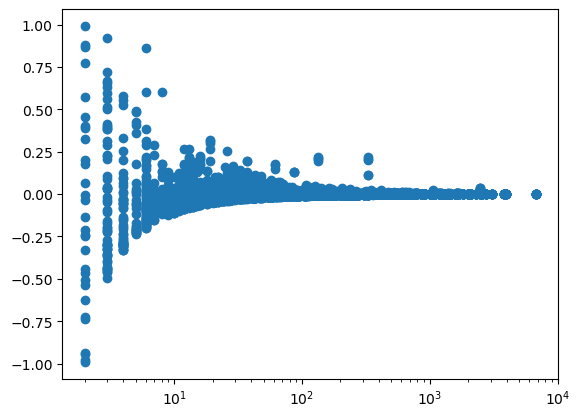

In [106]:
fig, ax = plt.subplots()

plt.scatter(spike_lfp_coupling_df["group_n_spikes"], spike_lfp_coupling_df["ppc"])
ax.set_xscale('log')
# plt.xlim(5, 3000)
plt.show()

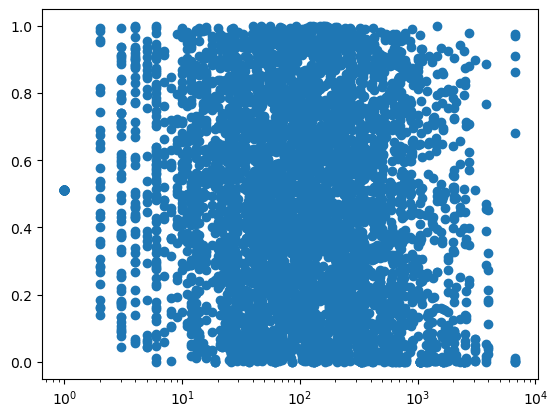

In [107]:
fig, ax = plt.subplots()

plt.scatter(spike_lfp_coupling_df["group_n_spikes"], spike_lfp_coupling_df["rayleightest"])
ax.set_xscale('log')
# plt.xlim(5, 3000)
plt.show()

# Adding the spike metadata

In [108]:
spike_metadata_df = MERGED_SPIKE_TRIAL_DF.drop_duplicates(subset="cluster_id_with_file_name").reset_index(drop=True)

In [109]:
spike_metadata_df = spike_metadata_df.drop(columns=["spike_times", 'Unnamed: 0', 'timestamp_isi', 'current_isi', 'closest_trial',
       'ephys_sample_from_trial_onset', 'lfp_sample_from_trial_onset'], errors="ignore")

In [110]:
spike_metadata_df

spike_clusters  cluster_id  1_5_ms_isi  1ms_isi  2ms_isi        amp  ch  \
0               103         103          12        2       32  14.402934   6   
1                83          83           9        3       26  13.022879   2   
2                65          65           2        1        3   8.466800   2   
3               106         106           0        0        0   9.491500   7   
4                93          93           0        0        3  10.994174   1   
..              ...         ...         ...      ...      ...        ...  ..   
166             272         272           0        0        0  11.487349  12   
167             252         252           0        0        0   9.257568   4   
168             268         268           0        0        1  12.729753   7   
169             275         275           0        0        0   9.945261  13   
170             255         255           0        0        0  14.943707   6   

     channel_group  depth         fr group  n_spikes  sh  si_unit_id  \
0              0.0  120.0   8.755451  good     30028   0        11.0   
1              0.0   40.0  10.683353  good     36640   0         5.0   
2              0.0   40.0   2.628268  good      9014   0         8.0   
3              0.0  140.0   0.383714  good      1316   0        13.0   
4              0.0   20.0   0.820787  good      2815   0         4.0   
..             ...    ...        ...   ...       ...  ..         ...   
166            0.0  240.0   0.859496  good      1770   0        30.0   
167            0.0   80.0   0.518126  good      1067   0        15.0   
168            0.0  140.0   0.570084  good      1174   0        20.0   
169            0.0  260.0   0.570569  good      1175   0        32.0   
170            0.0  120.0   0.691967  good      1425   0        18.0   

                                        recording_name  \
0    20230618_100636_standard_comp_to_omission_D2_s...   
1    20230618_100636_standard_comp_to_omission_D2_s...   
2    20230618_100636_standard_comp_to_omission_D2_s...   
3    20230618_100636_standard_comp_to_omission_D2_s...   
4    20230618_100636_standard_comp_to_omission_D2_s...   
..                                                 ...   
166  20230619_115321_standard_comp_to_omission_D3_s...   
167  20230619_115321_standard_comp_to_omission_D3_s...   
168  20230619_115321_standard_comp_to_omission_D3_s...   
169  20230619_115321_standard_comp_to_omission_D3_s...   
170  20230619_115321_standard_comp_to_omission_D3_s...   

                             cluster_id_with_file_name  
0    103_20230618_100636_standard_comp_to_omission_...  
1    83_20230618_100636_standard_comp_to_omission_D...  
2    65_20230618_100636_standard_comp_to_omission_D...  
3    106_20230618_100636_standard_comp_to_omission_...  
4    93_20230618_100636_standard_comp_to_omission_D...  
..                                                 ...  
166  272_20230619_115321_standard_comp_to_omission_...  
167  252_20230619_115321_standard_comp_to_omission_...  
168  268_20230619_115321_standard_comp_to_omission_...  
169  275_20230619_115321_standard_comp_to_omission_...  
170  255_20230619_115321_standard_comp_to_omission_...  

[171 rows x 16 columns]

In [111]:
merged_spike_lfp_coupling_df = pd.merge(left=spike_lfp_coupling_df, left_on="cluster_id_with_file_name", right=spike_metadata_df, right_on="cluster_id_with_file_name")

In [112]:
merged_spike_lfp_coupling_df.head()

cluster_id_with_file_name   outcome       ppc  \
0  25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.014516   
1  25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.031234   
2  25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.007536   
3  25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.070140   
4  25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.019772   

   rayleightest   band region      subj_id      date  group_n_spikes  phase  \
0      0.065389  gamma    BLA  25.20221214  20221214             120  trial   
1      0.084235  gamma    BLA  25.20221214  20221214              48  trial   
2      0.150058  gamma     LH  25.20221214  20221214             120  trial   
3      0.012902  gamma     LH  25.20221214  20221214              48  trial   
4      0.034982  gamma     MD  25.20221214  20221214             120  trial   

   ...       amp  ch  channel_group  depth        fr  group  n_spikes  sh  \
0  ...  7.987082  28            0.0  560.0  1.829565   good      5865   0   
1  ...  7.987082  28            0.0  560.0  1.829565   good      5865   0   
2  ...  7.987082  28            0.0  560.0  1.829565   good      5865   0   
3  ...  7.987082  28            0.0  560.0  1.829565   good      5865   0   
4  ...  7.987082  28            0.0  560.0  1.829565   good      5865   0   

   si_unit_id                                     recording_name  
0        22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  
1        22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  
2        22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  
3        22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  
4        22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  

[5 rows x 25 columns]

In [113]:
merged_spike_lfp_coupling_df.to_csv("./proc/lfp_spike_coupling/trial_based/merged_lfp_spike_coupling.csv")

In [ ]:
raise ValueError()

In [114]:
merged_spike_lfp_coupling_df["rayleigh_significant"] = merged_spike_lfp_coupling_df["rayleightest"] <= 0.05

In [115]:
merged_spike_lfp_coupling_df[merged_spike_lfp_coupling_df["rayleightest"] <= 0.05]

cluster_id_with_file_name   outcome       ppc  \
3     25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.070140   
4     25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.019772   
5     25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.086930   
7     25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.105623   
67    43_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.063442   
...                                                 ...       ...       ...   
4928  16_20230621_111240_standard_comp_to_omission_D...  rewarded  0.021542   
4931  16_20230621_111240_standard_comp_to_omission_D...  rewarded  0.028917   
4934  16_20230621_111240_standard_comp_to_omission_D...  rewarded  0.030591   
4937  16_20230621_111240_standard_comp_to_omission_D...  rewarded  0.023803   
4972  86_20230621_111240_standard_comp_to_omission_D...      lose  0.028741   

      rayleightest   band region      subj_id      date  group_n_spikes  \
3         0.012902  gamma     LH  25.20221214  20221214              48   
4         0.034982  gamma     MD  25.20221214  20221214             120   
5         0.005673  gamma     MD  25.20221214  20221214              48   
7         0.002252  gamma   mPFC  25.20221214  20221214              48   
67        0.007202  gamma   mPFC  43.20221214  20221214              63   
...            ...    ...    ...          ...       ...             ...   
4928      0.034404  theta     LH          1.4  20230621             111   
4931      0.015285  theta     MD          1.4  20230621             111   
4934      0.012715  theta   mPFC          1.4  20230621             111   
4937      0.026827  theta   vHPC          1.4  20230621             111   
4972      0.043857  gamma    BLA          1.4  20230621              75   

      phase  ...  ch  channel_group  depth        fr  group  n_spikes  sh  \
3     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
4     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
5     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
7     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
67    trial  ...  22            0.0  440.0  3.339073   good     10704   0   
...     ...  ...  ..            ...    ...       ...    ...       ...  ..   
4928  trial  ...   6            0.0  120.0  1.060053   good      3700   0   
4931  trial  ...   6            0.0  120.0  1.060053   good      3700   0   
4934  trial  ...   6            0.0  120.0  1.060053   good      3700   0   
4937  trial  ...   6            0.0  120.0  1.060053   good      3700   0   
4972  trial  ...  13            0.0  260.0  0.805067   good      2810   0   

      si_unit_id                                     recording_name  \
3           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
4           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
5           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
7           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
67          16.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
...          ...                                                ...   
4928        18.0  20230621_111240_standard_comp_to_omission_D5_s...   
4931        18.0  20230621_111240_standard_comp_to_omission_D5_s...   
4934        18.0  20230621_111240_standard_comp_to_omission_D5_s...   
4937        18.0  20230621_111240_standard_comp_to_omission_D5_s...   
4972        30.0  20230621_111240_standard_comp_to_omission_D5_s...   

      rayleigh_significant  
3                     True  
4                     True  
5                     True  
7                     True  
67                    True  
...                    ...  
4928                  True  
4931                  True  
4934                  True  
4937                  True  
4972                  True  

[454 rows x 26 columns]

In [116]:
merged_spike_lfp_coupling_df[merged_spike_lfp_coupling_df["rayleightest"] <= 0.05]["cluster_id_with_file_name"].unique().shape

(126,)

In [117]:
merged_spike_lfp_coupling_df[merged_spike_lfp_coupling_df["rayleigh_significant"]].groupby(["region", "band", "outcome", "phase"]).count()

cluster_id_with_file_name  ppc  rayleightest  \
region band  outcome  phase                                                 
BLA    gamma lose     trial                          4    4             4   
             omission trial                          3    3             3   
             rewarded trial                          4    4             4   
             win      trial                          6    6             6   
       theta lose     trial                         40   40            40   
             omission trial                          6    6             6   
             rewarded trial                         15   15            15   
             win      trial                         19   19            19   
LH     gamma lose     trial                          3    3             3   
             omission trial                          6    6             6   
             rewarded trial                          4    4             4   
             win      trial                          6    6             6   
       theta lose     trial                         35   35            35   
             omission trial                          8    8             8   
             rewarded trial                         12   12            12   
             win      trial                         19   19            19   
MD     gamma lose     trial                          2    2             2   
             omission trial                          5    5             5   
             rewarded trial                          7    7             7   
             win      trial                          7    7             7   
       theta lose     trial                         36   36            36   
             omission trial                          8    8             8   
             rewarded trial                         16   16            16   
             win      trial                         20   20            20   
mPFC   gamma lose     trial                         11   11            11   
             omission trial                          7    7             7   
             rewarded trial                         10   10            10   
             win      trial                          6    6             6   
       theta lose     trial                         25   25            25   
             omission trial                          3    3             3   
             rewarded trial                         16   16            16   
             win      trial                         16   16            16   
vHPC   gamma lose     trial                          7    7             7   
             omission trial                          3    3             3   
             rewarded trial                          5    5             5   
             win      trial                          7    7             7   
       theta lose     trial                         26   26            26   
             omission trial                          6    6             6   
             rewarded trial                         10   10            10   
             win      trial                          5    5             5   

                             subj_id  date  group_n_spikes  spike_clusters  \
region band  outcome  phase                                                  
BLA    gamma lose     trial        4     4               4               4   
             omission trial        3     3               3               3   
             rewarded trial        4     4               4               4   
             win      trial        6     6               6               6   
       theta lose     trial       40    40              40              40   
             omission trial        6     6               6               6   
             rewarded trial       15    15              15              15   
             win      trial       19    19              19              19   
LH     gamma l

In [ ]:
# spike_lfp_coupling_df = spike_lfp_coupling_df[spike_lfp_coupling_df["fr"] >= 1]

In [ ]:
raise ValueError()

# Plotting the number of cells

In [118]:
sorted(current_spike_lfp_coupling_df["band"].unique(), reverse=True)

NameError: name 'current_spike_lfp_coupling_df' is not defined

In [119]:
from collections import OrderedDict

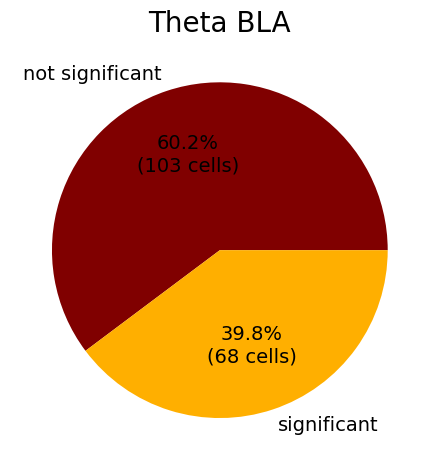

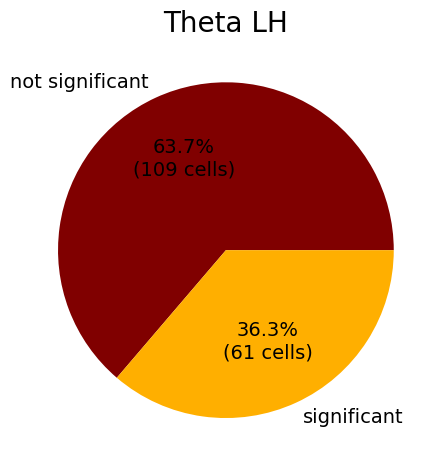

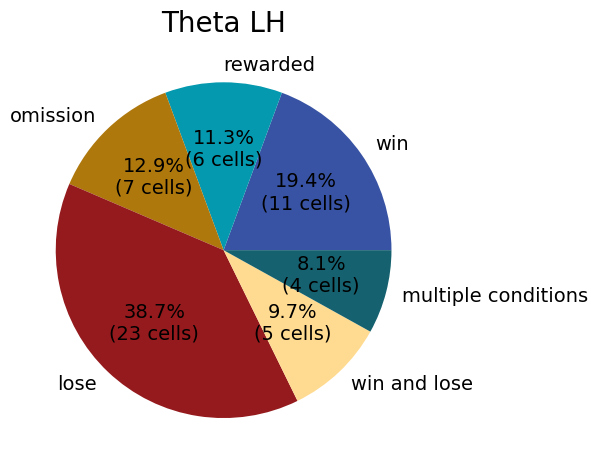

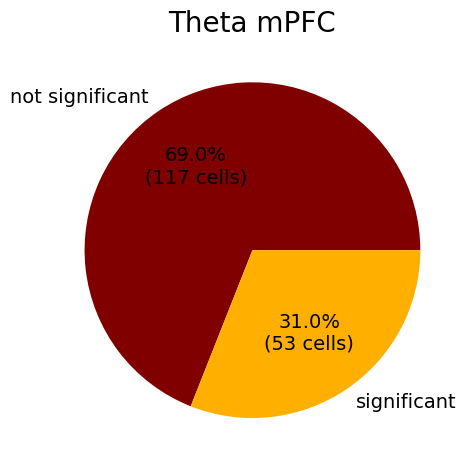

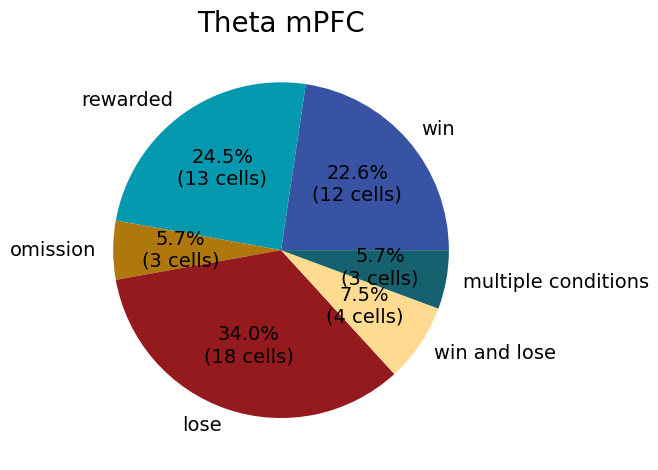

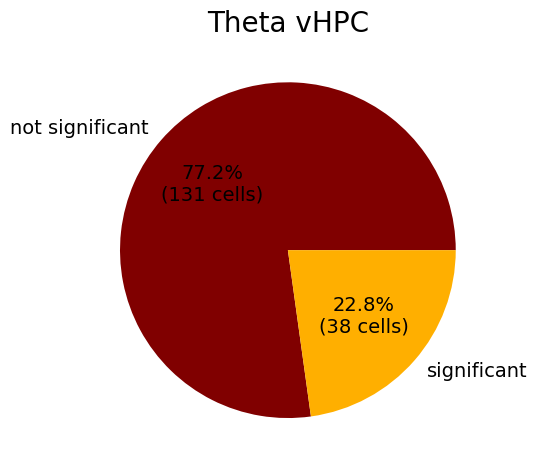

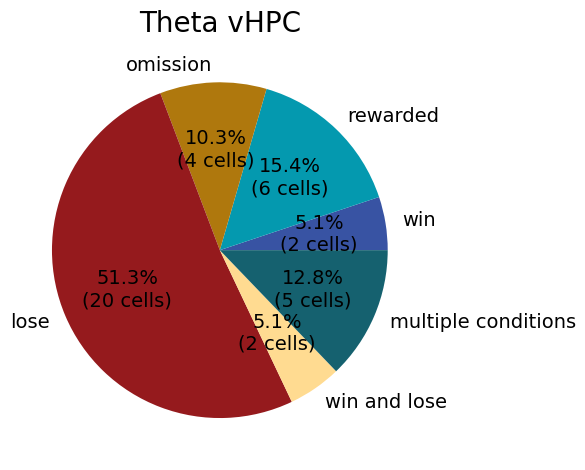

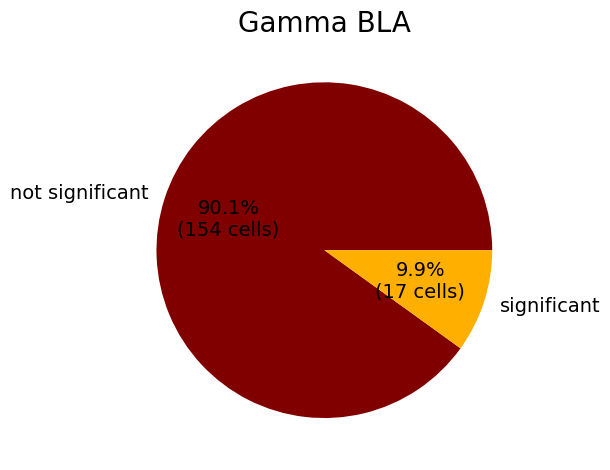

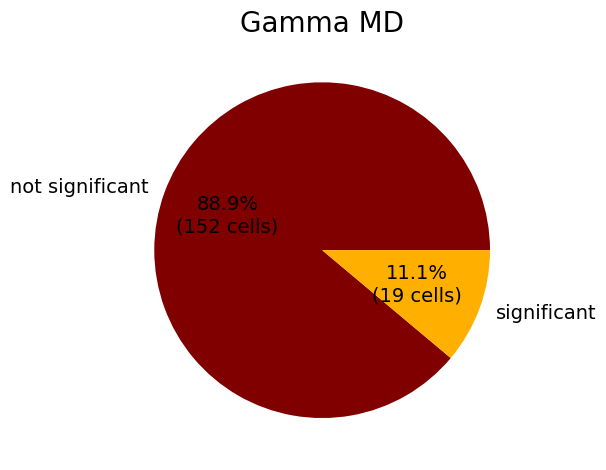

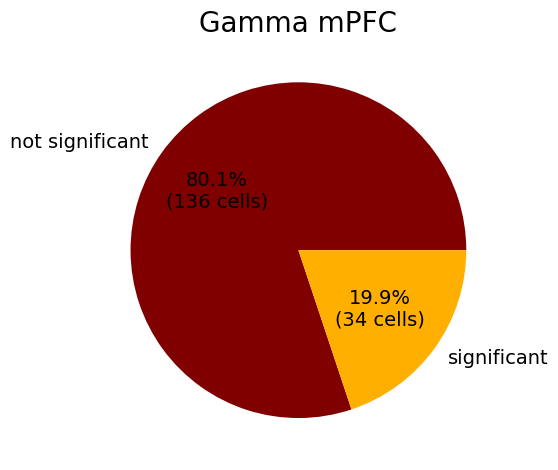

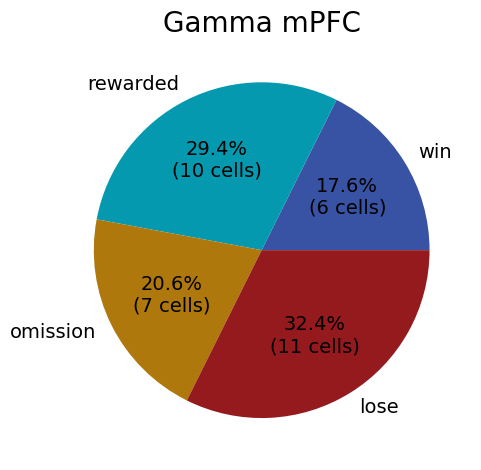

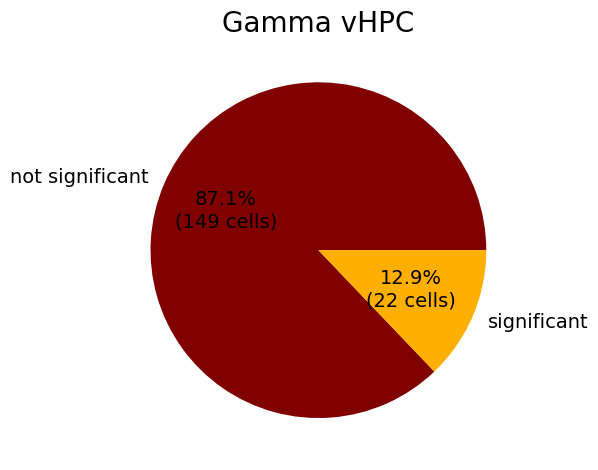

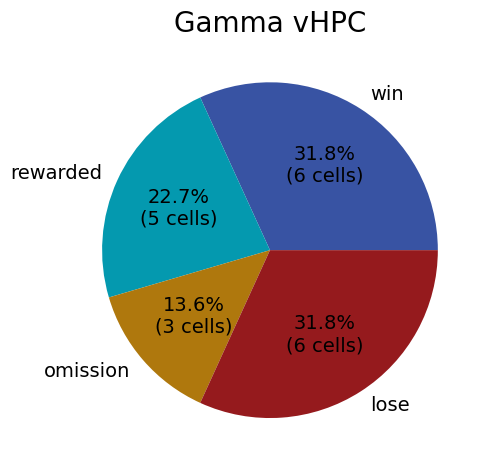

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


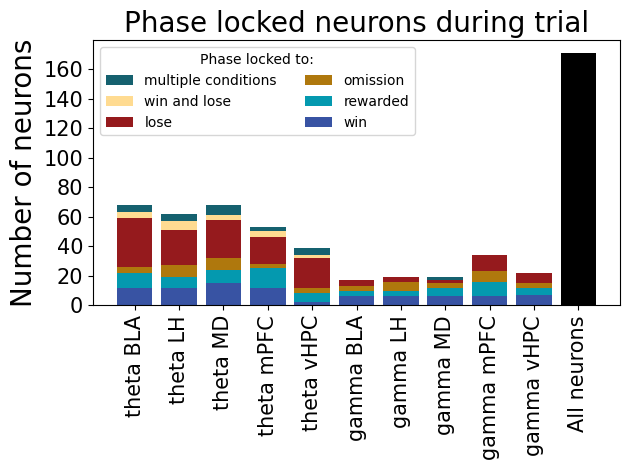

In [165]:
trial_significant_band_and_region_df = []
for phase in merged_spike_lfp_coupling_df["phase"].unique():
    current_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[merged_spike_lfp_coupling_df["phase"] == phase].copy()
    band_region_to_neurons = OrderedDict()
    for band, region in product(sorted(current_spike_lfp_coupling_df["band"].unique(), reverse=True), sorted(current_spike_lfp_coupling_df["region"].unique(), reverse=False)):
        # plt.figure(figsize=(24,6))
        fig, ax = plt.subplots()
        plt.title("{} {}".format(band.capitalize(), region), fontsize=20)
        band_and_region_df = current_spike_lfp_coupling_df.dropna(subset="rayleightest")[(current_spike_lfp_coupling_df["band"] == band) & (current_spike_lfp_coupling_df["region"] == region)]
        
        significant_band_and_region_df = band_and_region_df[(band_and_region_df["rayleightest"] <= 0.05)]
        if phase == "trial":
            trial_significant_band_and_region_df.append(significant_band_and_region_df)
        # significant_band_and_region_df = band_and_region_df[(current_spike_lfp_coupling_df["ppc"] >= 0.1)]
    
        current_spike_lfp_coupling_df
        # Group by neuron_id and get sets of outcomes for each neuron
        grouped = significant_band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)
        
        for index, value in grouped.items():
            if len(value) == 2 and "win" in value and "lose" in value:
                grouped[index] = frozenset({"win and lose"})
            elif len(value) >= 2:
                grouped[index] = frozenset({"multiple conditions"})
        significant_labels = ["not significant", "significant"]
        pie_data = [len(band_and_region_df["cluster_id_with_file_name"].unique()) - len(grouped), len(grouped)]
        plt.pie(pie_data, labels=significant_labels, autopct=lambda pct: func(pct, pie_data), textprops={'fontsize': 14}, colors=[OUTCOME_TO_COLOR[label] for label in significant_labels])
        plt.tight_layout()
        # plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_significant.eps".format(band, region))
        # plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_significant.png".format(band, region))
        plt.show()
        
        
        
        
        
        
        fig, ax = plt.subplots()
        plt.title("{} {}".format(band.capitalize(), region), fontsize=20)
        
        # Count how many neurons are associated with each unique combination of trial outcomes
        outcome_combinations = Counter(grouped)
        
        outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
        
        # outcome_combinations["not_significant"] = len(band_and_region_df["cluster_id_with_file_name"].unique()) - len(grouped)
        
        temp_dict = collections.OrderedDict({k:v for k,v in sorted(outcome_combinations.items(), reverse=True) if "multiple" not in k and "and" not in k})
        temp_dict.update({k:v for k,v in outcome_combinations.items() if "win and lose" in k})

        temp_dict.update({k:v for k,v in outcome_combinations.items() if "multiple" in k})
        outcome_combinations = temp_dict

        band_region_to_neurons[(band, region)] = outcome_combinations.values(), outcome_combinations.keys()
        
        
        plt.pie(outcome_combinations.values(), labels=outcome_combinations.keys(), autopct=lambda pct: func(pct, list(outcome_combinations.values())), textprops={'fontsize': 14}, colors=[OUTCOME_TO_COLOR[label] for label in outcome_combinations.keys()])
        plt.tight_layout()
        # plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_all_labels.png".format(band, region))
        # plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_all_labels.eps".format(band, region))
        
        plt.show()


    fig, ax = plt.subplots()

    
    # Variables to store the bottom values for each stack
    bottoms = [0] * len(band_region_to_neurons)
    
    for i, ((band, region), (heights, labels)) in enumerate(band_region_to_neurons.items()):
        # Loop through each sub-category to create stacked bars
        for height, label in zip(heights, labels):
            ax.bar("{} {}".format(band, region), height, label=label if i == 0 else "", bottom=bottoms[i], color=OUTCOME_TO_COLOR[label])
            bottoms[i] += height
    ax.bar("All neurons", len(band_and_region_df["cluster_id_with_file_name"].unique()), color="black")
    
    ax.set_ylabel('Number of neurons', fontsize=20)
    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(fontsize=15)

    ax.set_title('Phase locked neurons during {}'.format(phase), fontsize=20)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [labels.index(label) for label in ['multiple conditions', 'win and lose', 'lose', 'omission', 'rewarded', 'win']]

    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title='Phase locked to:', ncol=2, fontsize=10)


    # ax.legend()
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/{}_rayleigh_lfp_spike_coupled_bar.png".format(phase))
    plt.savefig("./proc/lfp_spike_coupling/{}_rayleigh_lfp_spike_coupled_bar.eps".format(phase))
    plt.show()

In [160]:
len(value)

1

In [155]:
value

frozenset({'win'})

In [121]:
trial_significant_band_and_region_df = pd.concat(trial_significant_band_and_region_df)

In [122]:
trial_significant_band_and_region_df = pd.DataFrame(trial_significant_band_and_region_df.groupby(["band", "region", "cluster_id_with_file_name"])["outcome"].apply(list)).reset_index()

In [123]:
trial_significant_band_and_region_df["outcome_numbers"] = trial_significant_band_and_region_df["outcome"].apply(lambda x: len(x))

In [124]:
trial_significant_band_and_region_df = trial_significant_band_and_region_df[trial_significant_band_and_region_df["outcome_numbers"] >= 2]

In [125]:
trial_significant_band_and_region_df

band region                          cluster_id_with_file_name  \
41   gamma     MD  162_20230620_114347_standard_comp_to_omission_...   
45   gamma     MD  25_20221214_125409_om_and_comp_6_1_top_1_base_...   
119  theta    BLA  139_20230618_100636_standard_comp_to_omission_...   
132  theta    BLA  227_20230620_114347_standard_comp_to_omission_...   
145  theta    BLA  34_20230617_115521_standard_comp_to_omission_D...   
150  theta    BLA  42_20230620_114347_standard_comp_to_omission_D...   
154  theta    BLA  45_20230620_114347_standard_comp_to_omission_D...   
159  theta    BLA  48_20230620_114347_standard_comp_to_omission_D...   
160  theta    BLA  58_20230620_114347_standard_comp_to_omission_D...   
166  theta    BLA  68_20230620_114347_standard_comp_to_omission_D...   
178  theta    BLA  93_20230618_100636_standard_comp_to_omission_D...   
182  theta     LH  124_20230620_114347_standard_comp_to_omission_...   
196  theta     LH  17_20230617_115521_standard_comp_to_omission_D...   
199  theta     LH  227_20230620_114347_standard_comp_to_omission_...   
213  theta     LH  34_20230617_115521_standard_comp_to_omission_D...   
214  theta     LH  36_20230621_111240_standard_comp_to_omission_D...   
217  theta     LH  42_20230620_114347_standard_comp_to_omission_D...   
218  theta     LH  43_20230617_115521_standard_comp_to_omission_D...   
225  theta     LH  48_20230620_114347_standard_comp_to_omission_D...   
230  theta     LH  68_20230620_114347_standard_comp_to_omission_D...   
234  theta     LH  7_20230621_111240_standard_comp_to_omission_D5...   
240  theta     LH  93_20230618_100636_standard_comp_to_omission_D...   
243  theta     MD  119_20230620_114347_standard_comp_to_omission_...   
260  theta     MD  227_20230620_114347_standard_comp_to_omission_...   
276  theta     MD  34_20230617_115521_standard_comp_to_omission_D...   
278  theta     MD  36_20230621_111240_standard_comp_to_omission_D...   
281  theta     MD  42_20230620_114347_standard_comp_to_omission_D...   
282  theta     MD  43_20230617_115521_standard_comp_to_omission_D...   
289  theta     MD  48_20230620_114347_standard_comp_to_omission_D...   
300  theta     MD  74_20230621_111240_standard_comp_to_omission_D...   
301  theta     MD  7_20230621_111240_standard_comp_to_omission_D5...   
308  theta     MD  93_20230618_100636_standard_comp_to_omission_D...   
309  theta   mPFC  114_20230617_115521_standard_comp_to_omission_...   
310  theta   mPFC  118_20230618_100636_standard_comp_to_omission_...   
336  theta   mPFC  35_20230617_115521_standard_comp_to_omission_D...   
339  theta   mPFC  40_20230617_115521_standard_comp_to_omission_D...   
344  theta   mPFC  45_20230620_114347_standard_comp_to_omission_D...   
348  theta   mPFC  48_20230620_114347_standard_comp_to_omission_D...   
355  theta   mPFC  7_20230621_111240_standard_comp_to_omission_D5...   
363  theta   vHPC  118_20230618_100636_standard_comp_to_omission_...   
381  theta   vHPC  34_20230617_115521_standard_comp_to_omission_D...   
387  theta   vHPC  45_20230620_114347_standard_comp_to_omission_D...   
391  theta   vHPC  50_20230618_100636_standard_comp_to_omission_D...   
392  theta   vHPC  58_20230620_114347_standard_comp_to_omission_D...   
393  theta   vHPC  68_20230620_114347_standard_comp_to_omission_D...   
400  theta   vHPC  93_20230618_100636_standard_comp_to_omission_D...   

                   outcome  outcome_numbers  
41         [omission, win]                2  
45    [rewarded, omission]                2  
119   [rewarded, omission]                2  
132  [rewarded, lose, win]                3  
145            [lose, win]                2  
150            [lose, win]                2  
154            [lose, win]                2  
159  [rewarded, lose, win]                3  
160   [rewarded, omission]                2  
166            [lose, win]                2  
178  [rewarded, lose, win]                3  
182            [lose, win]                2  
196            [lose, w

In [128]:
from itertools import combinations


In [129]:
region_and_band_to_counts = []
for region in trial_significant_band_and_region_df["region"].unique():
    for band in trial_significant_band_and_region_df["band"].unique():
        current_df = trial_significant_band_and_region_df[(trial_significant_band_and_region_df["region"] == region) & (trial_significant_band_and_region_df["band"] == band)]

        pair_counts = Counter()
        for lst in current_df["outcome"]:
            # Extracting all pairs (combinations of 2) from the list
            pairs = combinations(lst, 2)
            for pair in pairs:
                # Sorting the pair to avoid counting (item1, item2) and (item2, item1) separately
                sorted_pair = tuple(sorted(pair))
                pair_counts[sorted_pair] += 1

        for (outcome_1, outcome_2), count in pair_counts.items():
            region_and_band_to_counts.append({"outcome": sorted([outcome_1, outcome_2]), "band": band, "region": region, "counts": count})
        

In [154]:
pd.DataFrame(region_and_band_to_counts).sort_values(["band", "region", "counts"], ascending=[False, True, False])

outcome   band region  counts
8            [lose, win]  theta    BLA       7
6       [lose, rewarded]  theta    BLA       3
7        [rewarded, win]  theta    BLA       3
5   [omission, rewarded]  theta    BLA       2
9            [lose, win]  theta     LH       7
10      [lose, rewarded]  theta     LH       5
11       [rewarded, win]  theta     LH       1
2       [lose, rewarded]  theta     MD       7
3            [lose, win]  theta     MD       5
4        [rewarded, win]  theta     MD       2
12           [lose, win]  theta   mPFC       4
13      [lose, rewarded]  theta   mPFC       3
14           [lose, win]  theta   vHPC       3
15      [lose, rewarded]  theta   vHPC       3
16       [rewarded, win]  theta   vHPC       1
17  [omission, rewarded]  theta   vHPC       1
18      [lose, omission]  theta   vHPC       1
0        [omission, win]  gamma     MD       1
1   [omission, rewarded]  gamma     MD       1

In [131]:
current_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[merged_spike_lfp_coupling_df["phase"] == "trial"]

In [132]:
example_grouped_df = pd.DataFrame(current_spike_lfp_coupling_df[current_spike_lfp_coupling_df["rayleightest"] <= 0.05].groupby(["cluster_id_with_file_name", "outcome", "band"])["region"].apply(list)).reset_index()

In [133]:
current_spike_lfp_coupling_df

cluster_id_with_file_name   outcome       ppc  \
0     25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.014516   
1     25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.031234   
2     25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.007536   
3     25_20221214_125409_om_and_comp_6_1_top_1_base_...  omission  0.070140   
4     25_20221214_125409_om_and_comp_6_1_top_1_base_...  rewarded  0.019772   
...                                                 ...       ...       ...   
4995  86_20230621_111240_standard_comp_to_omission_D...  omission  0.400205   
4996  86_20230621_111240_standard_comp_to_omission_D...      lose -0.011876   
4997  86_20230621_111240_standard_comp_to_omission_D...  rewarded -0.001344   
4998  86_20230621_111240_standard_comp_to_omission_D...  omission  0.392062   
4999  86_20230621_111240_standard_comp_to_omission_D...      lose -0.009954   

      rayleightest   band region      subj_id      date  group_n_spikes  \
0         0.065389  gamma    BLA  25.20221214  20221214             120   
1         0.084235  gamma    BLA  25.20221214  20221214              48   
2         0.150058  gamma     LH  25.20221214  20221214             120   
3         0.012902  gamma     LH  25.20221214  20221214              48   
4         0.034982  gamma     MD  25.20221214  20221214             120   
...            ...    ...    ...          ...       ...             ...   
4995      0.283376  theta   mPFC          1.4  20230621               2   
4996      0.885888  theta   mPFC          1.4  20230621              75   
4997      0.919908  theta   vHPC          1.4  20230621             683   
4998      0.285896  theta   vHPC          1.4  20230621               2   
4999      0.768421  theta   vHPC          1.4  20230621              75   

      phase  ...  ch  channel_group  depth        fr  group  n_spikes  sh  \
0     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
1     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
2     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
3     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
4     trial  ...  28            0.0  560.0  1.829565   good      5865   0   
...     ...  ...  ..            ...    ...       ...    ...       ...  ..   
4995  trial  ...  13            0.0  260.0  0.805067   good      2810   0   
4996  trial  ...  13            0.0  260.0  0.805067   good      2810   0   
4997  trial  ...  13            0.0  260.0  0.805067   good      2810   0   
4998  trial  ...  13            0.0  260.0  0.805067   good      2810   0   
4999  trial  ...  13            0.0  260.0  0.805067   good      2810   0   

      si_unit_id                                     recording_name  \
0           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
1           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
2           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
3           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
4           22.0  20221214_125409_om_and_comp_6_1_top_1_base_2_v...   
...          ...                                                ...   
4995        30.0  20230621_111240_standard_comp_to_omission_D5_s...   
4996        30.0  20230621_111240_standard_comp_to_omission_D5_s...   
4997        30.0  20230621_111240_standard_comp_to_omission_D5_s...   
4998        30.0  20230621_111240_standard_comp_to_omission_D5_s...   
4999        30.0  20230621_111240_standard_comp_to_omission_D5_s...   

      rayleigh_significant  
0                    False  
1                    False  
2                    False  
3                     True  
4                     True  
...                    ...  
4995                 False  
4996                 False  
4997                 False  
4998                 False  
4999                 False  

[5000 rows x 26 columns]

In [134]:
example_grouped_df["region_count"] = example_grouped_df["region"].apply(lambda x: len(x))

In [135]:
example_grouped_df = example_grouped_df[example_grouped_df["region_count"] >= 2].sort_values(["outcome", "band"]).reset_index(drop=True)

In [136]:
example_grouped_df

cluster_id_with_file_name outcome   band  \
0    114_20230617_115521_standard_comp_to_omission_...    lose  gamma   
1    274_20230619_115321_standard_comp_to_omission_...    lose  gamma   
2    48_20230618_100636_standard_comp_to_omission_D...    lose  gamma   
3    114_20230617_115521_standard_comp_to_omission_...    lose  theta   
4    118_20230618_100636_standard_comp_to_omission_...    lose  theta   
..                                                 ...     ...    ...   
98   5_20230617_115521_standard_comp_to_omission_D1...     win  theta   
99   60_20230617_115521_standard_comp_to_omission_D...     win  theta   
100  64_20230620_114347_standard_comp_to_omission_D...     win  theta   
101  68_20230620_114347_standard_comp_to_omission_D...     win  theta   
102  80_20230617_115521_standard_comp_to_omission_D...     win  theta   

                        region  region_count  
0                  [BLA, vHPC]             2  
1                     [LH, MD]             2  
2                 [mPFC, vHPC]             2  
3          [BLA, LH, MD, mPFC]             4  
4    [BLA, LH, MD, mPFC, vHPC]             5  
..                         ...           ...  
98               [BLA, LH, MD]             3  
99         [BLA, LH, MD, mPFC]             4  
100        [BLA, LH, MD, mPFC]             4  
101                  [BLA, LH]             2  
102        [BLA, LH, MD, mPFC]             4  

[103 rows x 5 columns]

In [137]:
example_grouped_df.groupby(["outcome", "band"]).count()

cluster_id_with_file_name  region  region_count
outcome  band                                                  
lose     gamma                          3       3             3
         theta                         39      39            39
omission gamma                          5       5             5
         theta                          6       6             6
rewarded gamma                          5       5             5
         theta                         17      17            17
win      gamma                          6       6             6
         theta                         22      22            22

In [138]:
from itertools import combinations

In [139]:
outcome_and_band_to_counts = []
for outcome in example_grouped_df["outcome"].unique():
    for band in example_grouped_df["band"].unique():
        current_df = example_grouped_df[(example_grouped_df["outcome"] == outcome) & (example_grouped_df["band"] == band)]

        pair_counts = Counter()
        for lst in current_df["region"]:
            # Extracting all pairs (combinations of 2) from the list
            pairs = combinations(lst, 2)
            for pair in pairs:
                # Sorting the pair to avoid counting (item1, item2) and (item2, item1) separately
                sorted_pair = tuple(sorted(pair))
                pair_counts[sorted_pair] += 1

        for (region_1, region_2), count in pair_counts.items():
            outcome_and_band_to_counts.append({"outcome": outcome, "band": band, "region": sorted([region_1, region_2]), "counts": count})
        

In [140]:
pd.DataFrame(outcome_and_band_to_counts).sort_values("counts", ascending=False).head(n=50)

outcome   band        region  counts
6       lose  theta      [LH, MD]      34
4       lose  theta     [BLA, MD]      31
3       lose  theta     [BLA, LH]      30
5       lose  theta   [BLA, mPFC]      22
7       lose  theta    [LH, mPFC]      22
8       lose  theta    [MD, mPFC]      22
9       lose  theta   [BLA, vHPC]      21
11      lose  theta    [MD, vHPC]      20
10      lose  theta    [LH, vHPC]      19
54       win  theta      [LH, MD]      17
12      lose  theta  [mPFC, vHPC]      15
55       win  theta     [BLA, LH]      14
56       win  theta     [BLA, MD]      14
57       win  theta   [BLA, mPFC]      11
36  rewarded  theta      [LH, MD]      11
59       win  theta    [MD, mPFC]      11
42  rewarded  theta    [MD, mPFC]      10
38  rewarded  theta     [BLA, MD]      10
58       win  theta    [LH, mPFC]      10
35  rewarded  theta   [BLA, mPFC]       9
40  rewarded  theta    [LH, mPFC]       8
37  rewarded  theta     [BLA, LH]       8
44  rewarded  theta  [mPFC, vHPC]       6
43  rewarded  theta    [MD, vHPC]       6
41  rewarded  theta    [LH, vHPC]       6
39  rewarded  theta   [BLA, vHPC]       6
45       win  gamma      [LH, MD]       5
17  omission  theta      [LH, MD]       5
60       win  theta   [BLA, vHPC]       3
14  omission  gamma      [LH, MD]       3
53       win  gamma   [BLA, vHPC]       2
52       win  gamma     [BLA, MD]       2
47       win  gamma    [LH, vHPC]       2
51       win  gamma     [BLA, LH]       2
49       win  gamma    [MD, vHPC]       2
29  rewarded  gamma      [LH, MD]       2
28  rewarded  gamma     [BLA, MD]       2
27  rewarded  gamma     [BLA, LH]       2
26  omission  theta  [mPFC, vHPC]       2
23  omission  theta   [BLA, vHPC]       2
22  omission  theta   [BLA, mPFC]       2
21  omission  theta    [MD, mPFC]       2
20  omission  theta    [LH, mPFC]       2
19  omission  theta     [BLA, MD]       2
18  omission  theta     [BLA, LH]       2
15  omission  gamma    [LH, mPFC]       2
61       win  theta    [LH, vHPC]       2
62       win  theta    [MD, vHPC]       2
50       win  gamma  [mPFC, vHPC]       1
0       lose  gamma   [BLA, vHPC]       1

In [141]:
list(pair_counts.keys())[0]

('LH', 'MD')

In [142]:
labels

['win', 'rewarded', 'omission', 'lose', 'multiple conditions']

In [ ]:
band_region_to_neurons

In [147]:
current_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[merged_spike_lfp_coupling_df["phase"] == "trial"].copy()
# current_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[merged_spike_lfp_coupling_df["phase"] == "pre_reward"].copy()
# current_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[merged_spike_lfp_coupling_df["phase"] == "post_reward"].copy()

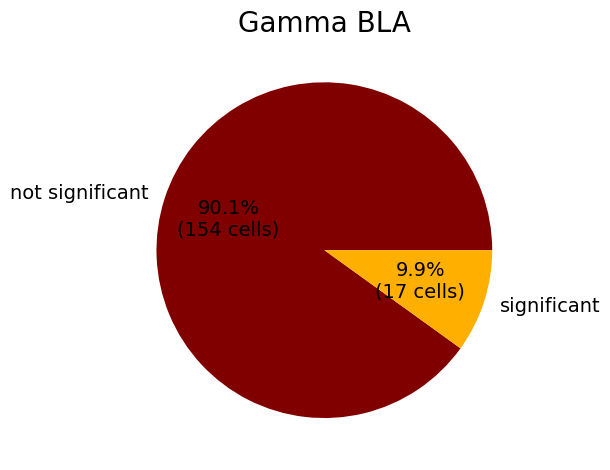

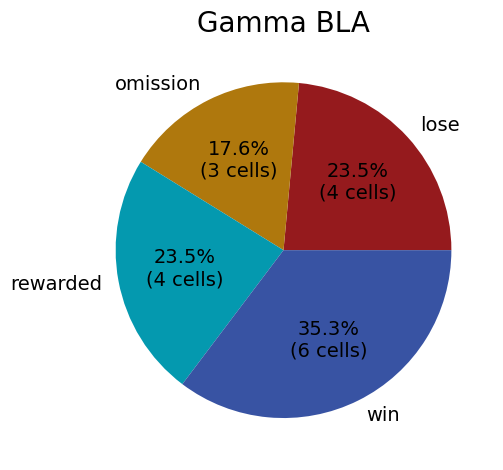

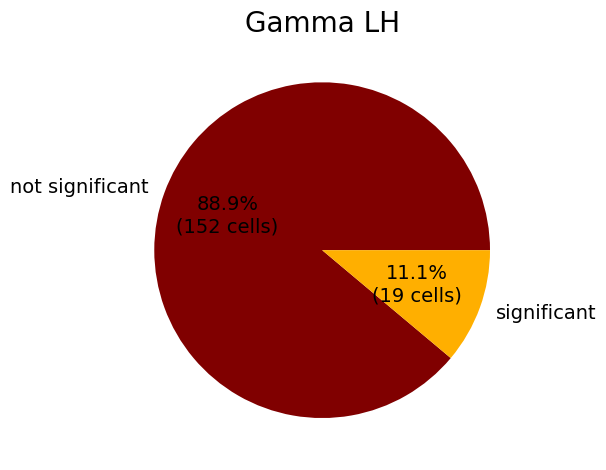

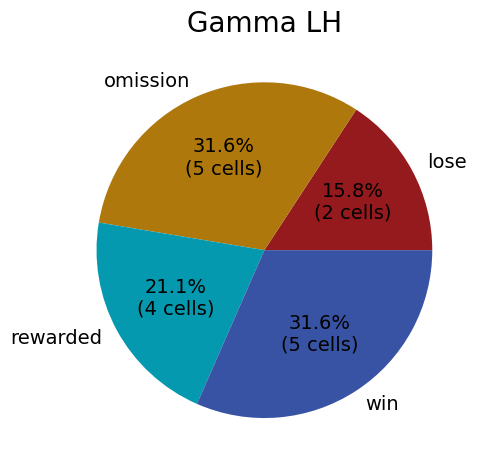

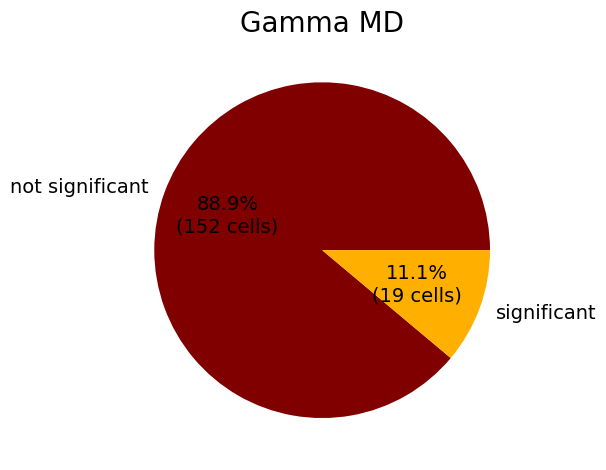

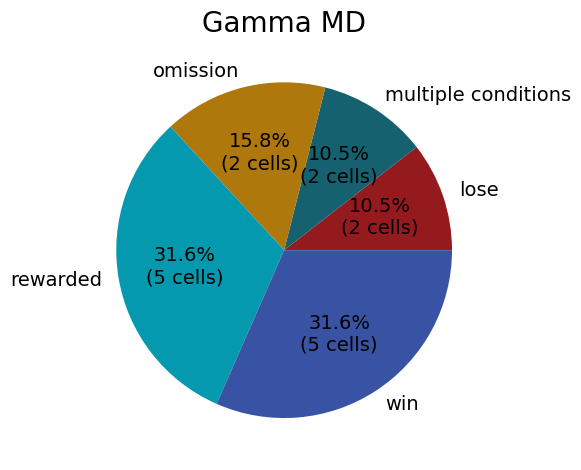

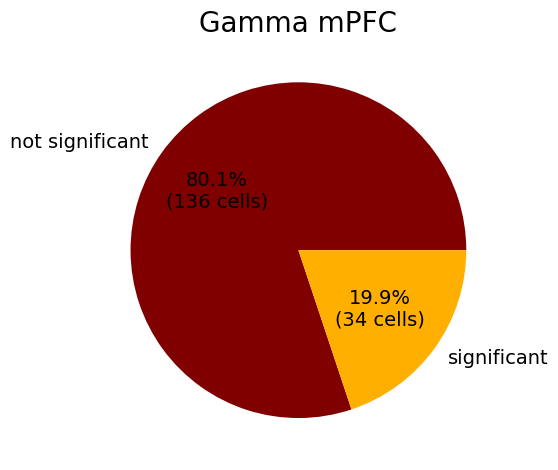

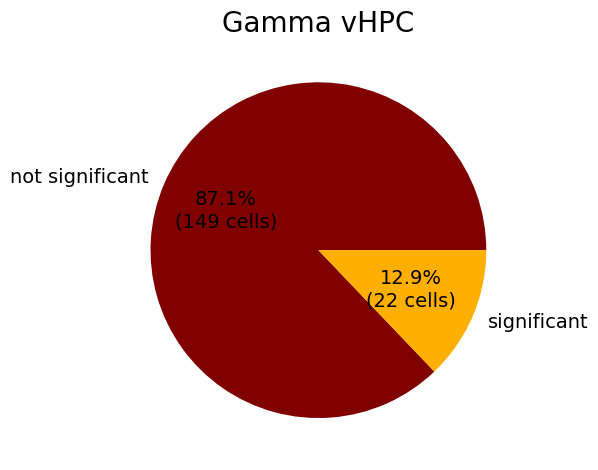

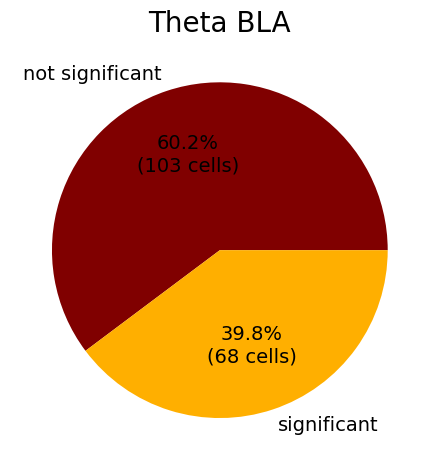

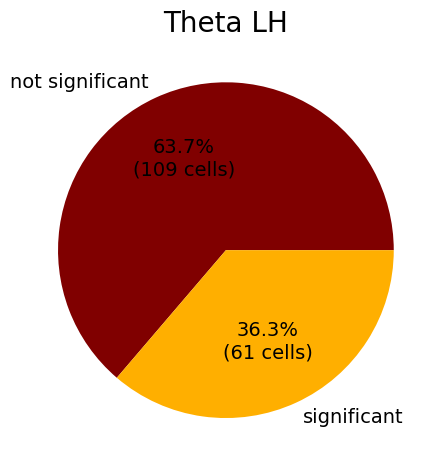

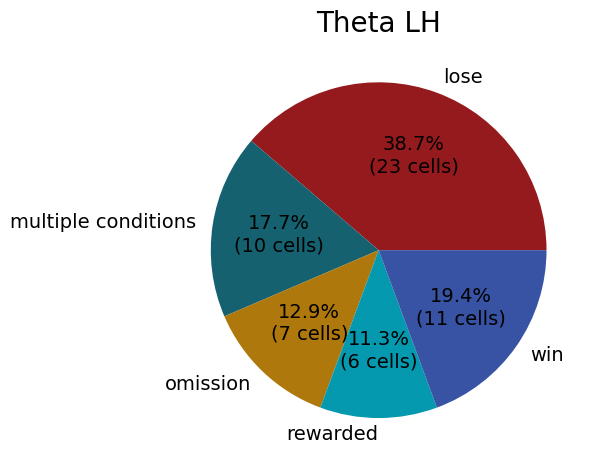

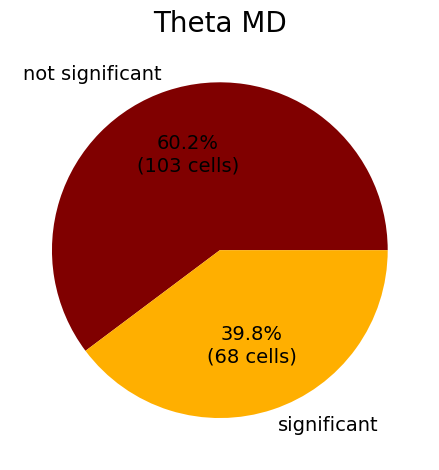

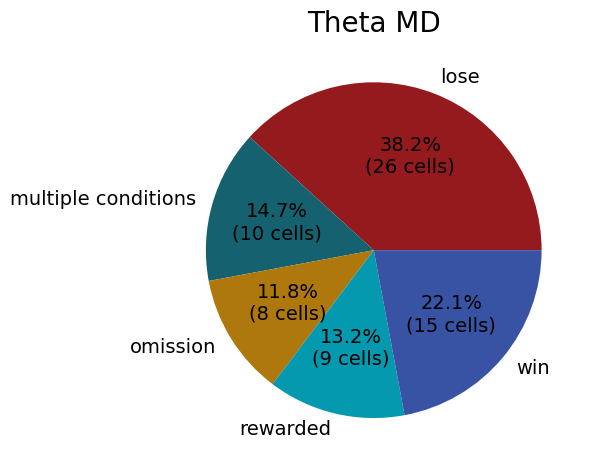

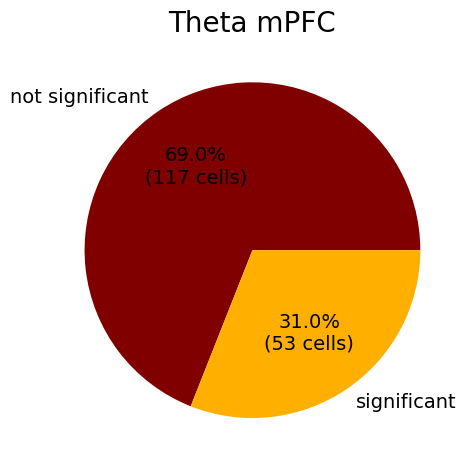

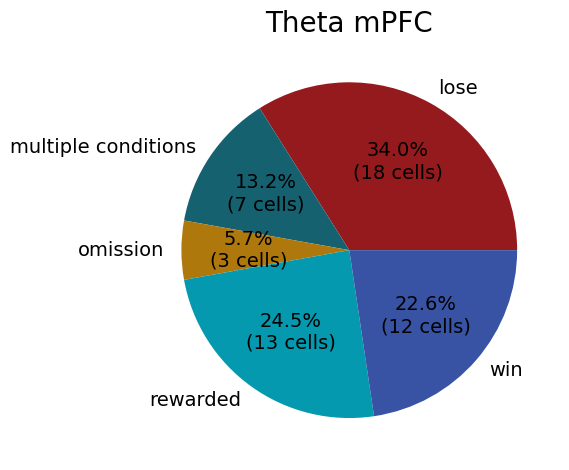

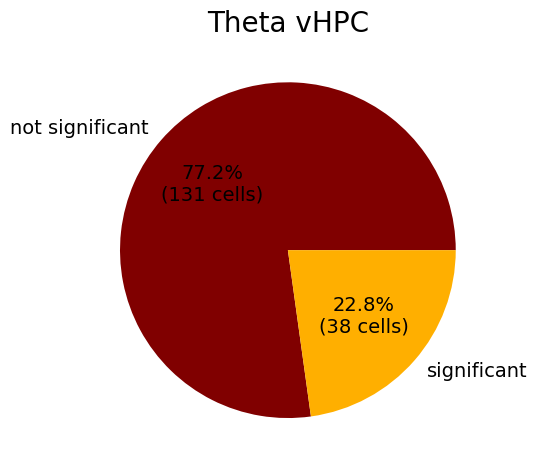

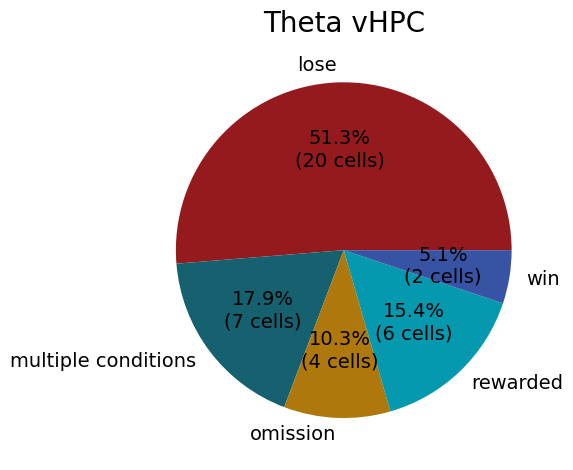

In [148]:
band_region_to_neurons = {}
for band, region in product(current_spike_lfp_coupling_df["band"].unique(), current_spike_lfp_coupling_df["region"].unique()):
    # plt.figure(figsize=(24,6))
    fig, ax = plt.subplots()
    plt.title("{} {}".format(band.capitalize(), region), fontsize=20)
    band_and_region_df = current_spike_lfp_coupling_df.dropna(subset="rayleightest")[(current_spike_lfp_coupling_df["band"] == band) & (current_spike_lfp_coupling_df["region"] == region)]
    
    significant_band_and_region_df = band_and_region_df[(current_spike_lfp_coupling_df["rayleightest"] <= 0.05)]
    # significant_band_and_region_df = band_and_region_df[(current_spike_lfp_coupling_df["ppc"] >= 0.1)]

    current_spike_lfp_coupling_df
    # Group by neuron_id and get sets of outcomes for each neuron
    grouped = significant_band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)
    
    for index, value in grouped.items():
        if len(value) >= 2:
            grouped[index] = frozenset({"multiple conditions"})
    significant_labels = ["not significant", "significant"]
    pie_data = [len(band_and_region_df["cluster_id_with_file_name"].unique()) - len(grouped), len(grouped)]
    plt.pie(pie_data, labels=significant_labels, autopct=lambda pct: func(pct, pie_data), textprops={'fontsize': 14}, colors=[OUTCOME_TO_COLOR[label] for label in significant_labels])
    plt.tight_layout()
    # plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_significant.eps".format(band, region))
    # plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_significant.png".format(band, region))
    plt.show()
    
    
    
    
    
    
    fig, ax = plt.subplots()
    plt.title("{} {}".format(band.capitalize(), region), fontsize=20)
    
    # Count how many neurons are associated with each unique combination of trial outcomes
    outcome_combinations = Counter(grouped)
    
    outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
    # outcome_combinations["not_significant"] = len(band_and_region_df["cluster_id_with_file_name"].unique()) - len(grouped)
    
    outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
    band_region_to_neurons[(band, region)] = outcome_combinations.values(), outcome_combinations.keys()
    plt.pie(outcome_combinations.values(), labels=outcome_combinations.keys(), autopct=lambda pct: func(pct, list(outcome_combinations.values())), textprops={'fontsize': 14}, colors=[OUTCOME_TO_COLOR[label] for label in outcome_combinations.keys()])
    plt.tight_layout()
    # plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_all_labels.png".format(band, region))
    # plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_all_labels.eps".format(band, region))
    
    plt.show()

In [149]:
band_region_to_neurons

{('gamma', 'BLA'): (odict_values([4, 3, 4, 6]),
  odict_keys(['lose', 'omission', 'rewarded', 'win'])),
 ('gamma', 'LH'): (odict_values([3, 6, 4, 6]),
  odict_keys(['lose', 'omission', 'rewarded', 'win'])),
 ('gamma', 'MD'): (odict_values([2, 2, 3, 6, 6]),
  odict_keys(['lose', 'multiple conditions', 'omission', 'rewarded', 'win'])),
 ('gamma', 'mPFC'): (odict_values([11, 7, 10, 6]),
  odict_keys(['lose', 'omission', 'rewarded', 'win'])),
 ('gamma', 'vHPC'): (odict_values([7, 3, 5, 7]),
  odict_keys(['lose', 'omission', 'rewarded', 'win'])),
 ('theta', 'BLA'): (odict_values([33, 9, 4, 10, 12]),
  odict_keys(['lose', 'multiple conditions', 'omission', 'rewarded', 'win'])),
 ('theta', 'LH'): (odict_values([24, 11, 8, 7, 12]),
  odict_keys(['lose', 'multiple conditions', 'omission', 'rewarded', 'win'])),
 ('theta', 'MD'): (odict_values([26, 10, 8, 9, 15]),
  odict_keys(['lose', 'multiple conditions', 'omission', 'rewarded', 'win'])),
 ('theta', 'mPFC'): (odict_values([18, 7, 3, 13, 12]),


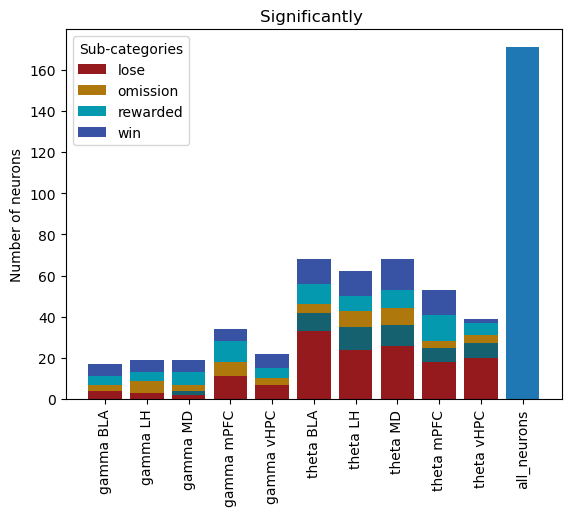

In [150]:
# Sample dictionary

data = band_region_to_neurons

fig, ax = plt.subplots()

# Variables to store the bottom values for each stack
bottoms = [0] * len(data)

for i, ((band, region), (heights, labels)) in enumerate(data.items()):
    # Loop through each sub-category to create stacked bars
    for height, label in zip(heights, labels):
        ax.bar("{} {}".format(band, region), height, label=label if i == 0 else "", bottom=bottoms[i], color=OUTCOME_TO_COLOR[label])
        bottoms[i] += height
ax.bar("all_neurons", len(band_and_region_df["cluster_id_with_file_name"].unique()))

ax.set_ylabel('Number of neurons')
plt.xticks(rotation=90)
ax.set_title('Significantly ')
ax.legend(title='Sub-categories')

plt.show()

In [ ]:
outcome_combinations.values()

In [ ]:
# create data
x = ['A', 'B', 'C', 'D']
y1 = [10, 20, 10, 30]
y2 = [20, 25, 15, 25]
 
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y2, bottom=y2, color='g')
# plt.bar(x, y2, bottom=y1, color='y')
plt.show()

In [ ]:
spike_lfp_coupling_df

In [ ]:
# wilcoxon_df = TRACE_AND_SPIKE_DF[TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].isin(merged_spike_lfp_coupling_df["cluster_id_with_file_name"].unique())]
wilcoxon_df = TRACE_AND_SPIKE_DF.copy()

In [ ]:
wilcoxon_df["recording_file"].unique()

In [ ]:
wilcoxon_df["baseline_or_trial"] = wilcoxon_df["lfp_sample_from_trial_onset"].apply(lambda x: "trial" if x >= 0 else "baseline")

In [ ]:
wilcoxon_df = wilcoxon_df.groupby(["cluster_id_with_file_name", "closest_trial", "trial_outcome", "baseline_or_trial"]).count()["time"].reset_index()

In [ ]:
wilcoxon_df.head()

In [ ]:
wilcoxon_df = pd.pivot_table(wilcoxon_df, values='time', index= ['cluster_id_with_file_name', 'closest_trial', 'trial_outcome'], columns='baseline_or_trial')
wilcoxon_df = wilcoxon_df.fillna(0)
wilcoxon_df = wilcoxon_df.reset_index()



In [ ]:
wilcoxon_df.head()

In [ ]:
cluster_to_wilcoxon = []
for trial_outcome in wilcoxon_df["trial_outcome"].unique():
    for cluster_id_with_file_name in wilcoxon_df["cluster_id_with_file_name"].unique():
        current_df = wilcoxon_df[(wilcoxon_df["trial_outcome"] == trial_outcome) & (wilcoxon_df["cluster_id_with_file_name"] == cluster_id_with_file_name)]
        try:
            stat, p_value = wilcoxon(current_df["baseline"], current_df["trial"])
        except:
            continue
            
        cluster_to_wilcoxon.append({"cluster_id_with_file_name": cluster_id_with_file_name, "trial_outcome": trial_outcome, "wilcoxon_stat": stat, "wilcoxon_p_value": p_value})
    

In [ ]:
cluster_to_wilcoxon = pd.DataFrame(cluster_to_wilcoxon)

In [ ]:
cluster_to_wilcoxon

In [ ]:
grouped_cluster_to_wilcoxon = cluster_to_wilcoxon[cluster_to_wilcoxon["wilcoxon_p_value"] <= 0.05].groupby(["cluster_id_with_file_name"]).count()

In [ ]:
multiple_conditions_clusters = grouped_cluster_to_wilcoxon[grouped_cluster_to_wilcoxon["trial_outcome"] >= 2].index

In [ ]:
cluster_to_wilcoxon[(cluster_to_wilcoxon["cluster_id_with_file_name"].isin(multiple_conditions_clusters)) & (cluster_to_wilcoxon["wilcoxon_p_value"] <= 0.05)].sort_values("cluster_id_with_file_name")

In [ ]:
significant_band_and_region_df.groupby(["cluster_id_with_file_name", "trial_outcome"]).count()

In [ ]:

# plt.figure(figsize=(24,6))
fig, ax = plt.subplots()
plt.title("Firing rate change".format(), fontsize=20)

significant_band_and_region_df = cluster_to_wilcoxon[(cluster_to_wilcoxon["wilcoxon_p_value"] <= 0.05)]
# significant_band_and_region_df = band_and_region_df[(current_spike_lfp_coupling_df["ppc"] >= 0.1)]

# current_spike_lfp_coupling_df
# Group by neuron_id and get sets of outcomes for each neuron
grouped = significant_band_and_region_df.sort_values("trial_outcome").groupby('cluster_id_with_file_name')['trial_outcome'].apply(frozenset)

for index, value in grouped.items():
    if len(value) >= 2:
        grouped[index] = frozenset({"multiple conditions"})
significant_labels = ["not significant", "significant"]
pie_data = [len(cluster_to_wilcoxon["cluster_id_with_file_name"].unique()) - len(grouped), len(grouped)]
plt.pie(pie_data, labels=significant_labels, autopct=lambda pct: func(pct, pie_data), textprops={'fontsize': 14}, colors=[OUTCOME_TO_COLOR[label] for label in significant_labels])
plt.tight_layout()
plt.savefig("./proc/wilcoxon/all_171_cells_wilcoxon_firing_rate_significant_or_not_pie_chart.eps".format())
plt.savefig("./proc/wilcoxon/all_171_cells_wilcoxon_firing_rate_significant_or_not_pie_chart.png".format())
plt.show()






fig, ax = plt.subplots()
plt.title("Firing rate change".format(), fontsize=20)

# Count how many neurons are associated with each unique combination of trial outcomes
outcome_combinations = Counter(grouped)

outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
# outcome_combinations["not_significant"] = len(band_and_region_df["cluster_id_with_file_name"].unique()) - len(grouped)

outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
plt.pie(outcome_combinations.values(), labels=outcome_combinations.keys(), autopct=lambda pct: func(pct, list(outcome_combinations.values())), textprops={'fontsize': 14}, colors=[OUTCOME_TO_COLOR[label] for label in outcome_combinations.keys()])
plt.tight_layout()
plt.savefig("./proc/wilcoxon/all_171_cells_wilcoxon_firing_rate_all_labels_pie_chart.eps".format())
plt.savefig("./proc/wilcoxon/all_171_cells_wilcoxon_firing_rate_all_labels_pie_chart.png".format())

plt.show()

In [ ]:
filtered_cluster_to_wilcoxon = cluster_to_wilcoxon[cluster_to_wilcoxon["wilcoxon_p_value"] <= 0.05].sort_values("cluster_id_with_file_name").reset_index(drop=True)

In [ ]:
filtered_cluster_to_wilcoxon

In [ ]:
# filtered_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[(merged_spike_lfp_coupling_df["phase"] == "trial") & (merged_spike_lfp_coupling_df["rayleightest"] <= 0.05)].copy()

# filtered_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[(merged_spike_lfp_coupling_df["phase"] == "pre_reward") & (merged_spike_lfp_coupling_df["rayleightest"] <= 0.05)].copy()

# filtered_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[(merged_spike_lfp_coupling_df["phase"] == "post_reward") & (merged_spike_lfp_coupling_df["rayleightest"] <= 0.05)].copy()


# filtered_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[(merged_spike_lfp_coupling_df["phase"] == "baseline_and_trial") & (merged_spike_lfp_coupling_df["rayleightest"] <= 0.05)].copy()

# filtered_spike_lfp_coupling_df = merged_spike_lfp_coupling_df[(merged_spike_lfp_coupling_df["phase"] == "baseline") & (merged_spike_lfp_coupling_df["rayleightest"] <= 0.05)].copy()

In [ ]:
rayleigh_and_wilcoxon = pd.merge(left=filtered_spike_lfp_coupling_df, left_on=["cluster_id_with_file_name", "outcome"], right=filtered_cluster_to_wilcoxon, right_on =["cluster_id_with_file_name", "trial_outcome"])

In [ ]:
rayleigh_and_wilcoxon

In [ ]:
rayleigh_and_wilcoxon.groupby(["band", "region", "outcome"]).count()

In [ ]:
cluster_to_wilcoxon

In [ ]:
raise ValueError()

In [ ]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF.drop_duplicates(["recording_file", "time", "current_subject"])

In [ ]:
TRACE_AND_SPIKE_DF = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [ ]:
TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"]

In [ ]:
len(band_and_region_df["cluster_id_with_file_name"].unique())

In [ ]:
outcome_combinations

In [ ]:
band_and_region_df.groupby("outcome")["rayleightest"].mean().index

In [ ]:
band_and_region_df.groupby("outcome")["rayleightest"].sem()

In [ ]:
band_and_region_df.groupby("outcome")["rayleightest"].mean().index.map(OUTCOME_TO_COLOR)

In [ ]:
spike_lfp_coupling_df

In [ ]:
band_and_region_df

In [ ]:
from itertools import chain, combinations
from collections import Counter


In [ ]:
# Function to get all subsets of a set
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(1, len(ss) + 1)))

In [ ]:
# Get unique trial outcomes
unique_outcomes = spike_lfp_coupling_df['outcome'].unique()

In [ ]:
neuron_counts = {}
for subset in all_subsets(unique_outcomes):
    subset_key = '&'.join(subset)
    filtered_df = band_and_region_df[band_and_region_df['outcome'].isin(subset)]
    unique_neurons = filtered_df['cluster_id_with_file_name'].unique()
    neuron_counts[subset_key] = len(unique_neurons)

In [ ]:
import collections

In [ ]:
# Group by neuron_id and get sets of outcomes for each neuron
grouped = band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)

# Count how many neurons are associated with each unique combination of trial outcomes
outcome_combinations = Counter(grouped)

outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}

outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))

In [ ]:
def combine_hex_values(d):
  d_items = sorted(d.items())
  tot_weight = sum(d.values())
  red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
  green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
  blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
  zpad = lambda x: x if len(x)==2 else '0' + x
  return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])

In [ ]:
combine_hex_values({"ffffff": 1.0, "0000ff": 0.5, "000000": 0.05})
# 'a4a4f6'
# >>> combine_hex_values({"ffffff": 1.0, "0000ff": 0.5, "000000": 0.5})
# '7f7fbf'
# >>> combine_hex_values({"ffffff": 0.05, "0000ff": 1.0, "000000": 0.05})
# '0b0bf3'

In [ ]:
matplotlib.colors.to_hex("orange", keep_alpha=False)

In [ ]:
[{color[1:]: 1.0 for color in [matplotlib.colors.to_hex(OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]} for key in outcome_combinations.keys()]

In [ ]:
[combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()]

In [ ]:
spike_lfp_coupling_df[spike_lfp_coupling_df["ppc"] >= 0.1]

In [ ]:
band_and_region_df.groupby("outcome")["rayleightest"]

In [ ]:
len(spike_lfp_coupling_df["cluster_id_with_file_name"].unique())


In [ ]:
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
    
    plt.title("{} {}".format(band, region), fontsize=20)
    plt.xlabel("Rayleigh p-value")
    plt.hist(band_and_region_df["rayleightest"])
    # plt.ylabel()
    plt.show()
    
    fig, ax = plt.subplots()

In [ ]:
grouped.index

In [ ]:
for index, group in zip(grouped.index, grouped):
    print()

In [ ]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # plt.figure(figsize=(24,6))
    fig, ax = plt.subplots()

    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    # Group by neuron_id and get sets of outcomes for each neuron
    grouped = band_and_region_df.groupby('outcome')['rayleightest'].apply(list)
    for outcome in grouped
    break
    # Count how many neurons are associated with each unique combination of trial outcomes
    outcome_combinations = Counter(grouped)
    
    outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
    
    outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
    
    plt.bar([key.replace("_", "\n") for key in outcome_combinations.keys()], outcome_combinations.values(), color=["#" + combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()])
    plt.xticks(rotation=22.5, fontsize=10)
    plt.title("{} {}".format(band, region), fontsize=20)
    plt.ylim(0, 15)
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/bar/{}_{}_lfp_spike_coupling_bar.png".format(band, region))
    plt.show()

In [ ]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # plt.figure(figsize=(24,6))
    fig, ax = plt.subplots()

    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    band_and_region_df = band_and_region_df[(spike_lfp_coupling_df["rayleightest"] <= 0.05) & (spike_lfp_coupling_df["ppc"]>= 0.001)]

    # Group by neuron_id and get sets of outcomes for each neuron
    grouped = band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)
    
    # Count how many neurons are associated with each unique combination of trial outcomes
    outcome_combinations = Counter(grouped)
    
    outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
    
    outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
    
    plt.bar([key.replace("_", "\n") for key in outcome_combinations.keys()], outcome_combinations.values(), color=["#" + combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()])
    plt.xticks(rotation=22.5, fontsize=15)
    plt.ylabel("Number of neurons", fontsize=15)
    plt.title("Phase-locked neurons in {} {}".format(band, region), fontsize=20)
    plt.ylim(0, 15)
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/bar/{}_{}_lfp_spike_coupling_bar.png".format(band, region))
    plt.show()

In [ ]:
all_outcomes = (band_and_region_df["outcome"].unique())

In [ ]:
raise ValueError()

In [ ]:
merged_spike_lfp_coupling_df["band"].unique()

In [ ]:
for band, region in list(product(merged_spike_lfp_coupling_df["band"].unique(), merged_spike_lfp_coupling_df["region"].unique())):
    current_df = merged_spike_lfp_coupling_df[(merged_spike_lfp_coupling_df["band"] == band) & (merged_spike_lfp_coupling_df["region"] == region)]
    current_df = current_df[["cluster_id_with_file_name", "outcome", "rayleigh_significant"]]
    current_df = current_df.pivot_table('rayleigh_significant', ['cluster_id_with_file_name'], 'outcome')
    current_df["significance_total"] = current_df["lose"] + current_df["omission"] + current_df["rewarded"] + current_df["win"]

    

In [ ]:
# current_df

current_df

In [ ]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # fig, ax = plt.subplots()
    # plt.figure(figsize=(12,12))
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    band_and_region_df = band_and_region_df[(spike_lfp_coupling_df["rayleightest"] <= 0.05) & (spike_lfp_coupling_df["ppc"]>= 0.001)]
    
    outcome_to_neurons = {}
    for outcome in sorted(band_and_region_df["outcome"].unique()):
        outcome_to_neurons[outcome] = set(band_and_region_df[band_and_region_df["outcome"] == outcome]["cluster_id_with_file_name"].values)
    # keys, value = zip(*outcome_to_neurons.items())
    # venn3(list(value), keys)

    venn(outcome_to_neurons, cmap=[OUTCOME_TO_COLOR[outcome] for outcome in sorted(band_and_region_df["outcome"].unique())], fontsize=20, figsize=(8,8))
    plt.title("{} {}".format(band, region), fontsize=20)

    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/venn/{}_{}_lfp_spike_coupling_venn.png".format(band, region))
    plt.show()


In [ ]:
keys, value = zip(*outcome_to_neurons.items())

In [ ]:
keys

In [ ]:
outcome_to_neurons.values()

In [ ]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    fig, ax = plt.subplots()
    plt.title("{} {}".format(band, region))
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region) & (spike_lfp_coupling_df["rayleightest"] <= 0.1)]
    
    
    
    plt.bar(x=band_and_region_df.groupby("outcome")["rayleightest"].count().index, height=band_and_region_df.groupby("outcome")["rayleightest"].count(), color=band_and_region_df.groupby("outcome")["rayleightest"].count().index.map(OUTCOME_TO_COLOR))
    plt.ylim(0,25)
    plt.show()
    # region_df.groupby("")

In [ ]:
raise ValueError()

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
id_and_outcome_to_stats.keys()

In [ ]:
all_phase_df = []
for key, value in id_and_outcome_to_stats.items():
    current_df = pd.DataFrame.from_dict(id_and_outcome_to_stats[key])
    current_df["region"] = key
    all_phase_df.append(current_df)

In [ ]:
all_phase_df = pd.concat(all_phase_df)

In [ ]:
raise ValueError()

In [ ]:
from astropy import units as u
data = np.array([130, 90, 0, 145])*u.deg

In [ ]:
# Creating a dictionary that we can add all dataframes to
id_and_outcome_to_stats = defaultdict(list)

# iterating through each band and each brain region
for radian_col, degree_col in zip(radians_spike_columns, degrees_spike_columns):
    # Iterating through each neuron
    for index, neuron_id in enumerate(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()):        
        print(col)
        print(neuron_id)
        # # Instantiating a new plot
        # fig, ax = plt.subplots()
        #Plotting the histogram
        figure, axis = plt.subplots(2, 2) 
        ax = plt.subplot(1,1,1, polar=True)
        plt.title(neuron_id)
        plt.xlabel(col)
        # Iterating through each trial outcome
        for outcome in TRACE_AND_SPIKE_DF[GROUPING].unique():
            print(outcome)
            # Getting all the rows that have this trial outcome and this neuron
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF[GROUPING] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            # Getting the phases of the current brain regions for all the spikes 
            radian_spike_phases = outcome_df[radian_col]
            binned_phases = np.digitize(radian_spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            

            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=OUTCOME_TO_COLOR[outcome], label=outcome, color=OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            
            # Calculating the ppc values
            ppc_val = PPC(radian_spike_phases)
            # Calculating the Rayleightest            
            rayleigh_val = rayleightest(outcome_df[degree_col]) 
            print("\tSpike phase histogram: {}".format(spike_phase_hist))
            print("\tppc_val: {}".format(ppc_val))
            print("\trayleigh_val: {}".format(rayleigh_val))


            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleigh_val})

        plt.legend()
        # plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        break
    break

In [ ]:
raise ValueError()
# Creating a dictionary that we can add all dataframes to
id_and_outcome_to_stats = defaultdict(list)

# Iterating through each brain region
for col in spike_columns:
    # Iterating through each neuron
    for index, neuron_id in enumerate(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()):        
        print(col)
        print(neuron_id)
        # # Instantiating a new plot
        # fig, ax = plt.subplots()
        #Plotting the histogram
        ax = plt.subplot(1,1,1, polar=True)
        plt.title(neuron_id)
        plt.xlabel(col)
        # Iterating through each trial outcome
        for outcome in TRACE_AND_SPIKE_DF[GROUPING].unique():
            print(outcome)
            # Getting all the rows that have this trial outcome and this neuron
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF[GROUPING] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            # Getting the phases of the current brain regions for all the spikes 
            spike_phases = outcome_df[col]
            binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            

            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=OUTCOME_TO_COLOR[outcome], label=outcome, color=OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            
            # Calculating the ppc values
            ppc_val = PPC(spike_phases)
            # Calculating the Rayleightest            
            rayleigh_val = rayleightest(spike_phases) 
            print("\tSpike phase histogram: {}".format(spike_phase_hist))
            print("\tppc_val: {}".format(ppc_val))
            print("\trayleigh_val: {}".format(rayleigh_val))


            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleigh_val})

        plt.legend()
        plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        
    

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
id_and_outcome_to_stats.keys()

In [ ]:
all_phase_df = []
for key, value in id_and_outcome_to_stats.items():
    current_df = pd.DataFrame.from_dict(id_and_outcome_to_stats[key])
    current_df["region"] = key
    all_phase_df.append(current_df)

In [ ]:
all_phase_df = pd.concat(all_phase_df)

In [ ]:
all_phase_df.sort_values("rayleightest").head(n=20)


id_and_outcome_to_stats = defaultdict(list)
for col in spike_columns:

    for id in range(len(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique())):
        fig, ax = plt.subplots()
        
        for outcome in TRACE_AND_SPIKE_DF[GROUPING].unique():
        
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF[GROUPING] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            
            spike_phases = outcome_df[col]
        
            N_BINS = 18
            PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
            binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            print(spike_phase_hist)
            
            #Plot
            ax = plt.subplot(1,1,1, polar=True)
            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=OUTCOME_TO_COLOR[outcome], label=outcome, color=OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            ppc_val = PPC(spike_phases)



            
            rayleightest(data) 
            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleightest(spike_phases)})
            plt.title(neuron_id)
            plt.xlabel(col)
        plt.legend()
        plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        break
    break

In [ ]:
ppc_df = pd.DataFrame(id_and_outcome_to_stats).dropna()

In [ ]:
ppc_df

In [ ]:
    sns.violinplot(x=ppc_df['outcome'], y=ppc_df['ppc'], palette=OUTCOME_TO_COLOR)

In [ ]:
fig, ax = plt.subplots()

# Create a separate violin plot for each group
for i, group in enumerate(ppc_df["outcome"].unique()):
    group_data = ppc_df[ppc_df['outcome'] == group]  # filter the data for this group
    sns.violinplot(x=group_data['outcome'], y=group_data['ppc'])
    # axs[i].set_title(f'Violin plot for {group}')

plt.tight_layout()
plt.show()

In [ ]:
# Create a histogram with Seaborn's 'histplot'
plt.figure(figsize=(10, 6))
sns.histplot(data=ppc_df, x='ppc', hue='outcome', multiple="stack", binwidth=0.01)

# Set labels and title
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Different Groups')

# Show plot
plt.show()

In [ ]:
spike_phases = TRACE_AND_SPIKE_DF["mPFC_trial_spike_phase"]

In [ ]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
spike_phase_hist = np.zeros(N_BINS+1)
for bin in range(0, N_BINS + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(PHASE_BINS, spike_phase_hist, width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0)

# OLD MERGING CODE

In [ ]:
raise ValueError()

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"] = BASIC_LFP_TRACES_DF.apply(lambda x: MERGED_SPIKE_TRIAL_DF[(MERGED_SPIKE_TRIAL_DF["recording_name"] == x["recording_file"]) & (MERGED_SPIKE_TRIAL_DF["closest_trial"] == x["time_stamp_index"])], axis=1)

In [ ]:
BASIC_LFP_TRACES_DF["has_spike_df"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: not x.empty)

In [ ]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["has_spike_df"]].reset_index(drop=True)

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: {k: sorted(list(v)) for k, v in x.groupby("cluster_id")["lfp_sample_from_trial_onset"]})

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: x.groupby("cluster_id")["lfp_sample_from_trial_onset"].apply(list).reset_index(name='lfp_sample_from_trial_onset'))

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [ ]:
BASIC_LFP_TRACES_DF.head()

In [ ]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [ ]:
FREQ_BAND = [4, 12]


In [ ]:
for col in trace_columns:
    region_name = "_".join(col.split("_")[:2])
    BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)] = BASIC_LFP_TRACES_DF[col].apply(lambda x: filtfilt(numerator_b, denominator_a, x, padtype=None))

    BASIC_LFP_TRACES_DF["{}_phase".format(region_name)] = BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))
    


- Plotting an example filtered trace

In [ ]:
MERGED_SPIKE_TRIAL_DF.head()

In [ ]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_filtered"].iloc[0])

current_spike_df = BASIC_LFP_TRACES_DF["spike_df"].iloc[0]
current_unit_spikes = current_spike_df[current_spike_df["cluster_id"] == current_spike_df["cluster_id"].unique()[0]]["lfp_sample_from_trial_onset"].values

for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_phase"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
# plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)
for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

In [ ]:
BASIC_LFP_TRACES_DF.head()

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

In [ ]:
spike_phases = []
for spike_time in spike_times:
    spike_phases.append(phase[int(round(spike_time*fs))])

# Plotting phase and LFP

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[5].columns

In [ ]:
BASIC_LFP_TRACES_DF.columns

In [ ]:
rec_file = MERGED_SPIKE_TRIAL_DF["recording_name"].unique()[0]

In [ ]:
example_trial = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["recording_file"] == rec_file].iloc[15]

In [ ]:
example_trial.index

In [ ]:
example_start, example_end = example_trial["trial_ephys_timestamp_range"]

In [ ]:
example_spike_df = MERGED_SPIKE_TRIAL_DF[MERGED_SPIKE_TRIAL_DF["recording_name"] == rec_file]

In [ ]:
example_spike_df = example_spike_df[(example_spike_df["spike_times"] > example_start) & (example_spike_df["spike_times"] < example_end)]

In [ ]:
example_spike_df[["spike_clusters", "spike_times"]]

In [ ]:
example_spike_df

In [ ]:
merged_df = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [ ]:
merged_df.columns

In [ ]:
BASIC_LFP_TRACES_DF

In [ ]:
# Group by 'Group' column and get group sizes
group_sizes = example_spike_df.groupby('cluster_id').size()

# Identify the group with the largest count
group_with_max_count = group_sizes.idxmax()
print(f"The group with the largest count is: {group_with_max_count}")

# If you also want to retrieve the actual rows of that group:
max_group_data = example_spike_df[example_spike_df['cluster_id'] == group_with_max_count]["spike_times"]


In [ ]:
example_times = example_trial["lfp_trial_all_ephys_index"]

In [ ]:
example_trace = example_trial["mPFC_baseline_lfp_trace"]

In [ ]:
aligned_spike_times = find_closest_nums(max_group_data, example_trial["lfp_trial_all_ephys_index"])

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trace)
for time_stamp in aligned_spike_times:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_filtered"])
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_phase"])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
aligned_spike_indices = find_closest_indices(max_group_data, example_times)

In [ ]:
spike_phases = []
for spike_time in aligned_spike_indices:
    spike_phases.append(example_trial["mPFC_trial_phase"][spike_time])


In [ ]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
spike_phase_hist = np.zeros(N_BINS+1)
for bin in range(0, N_BINS + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(PHASE_BINS, spike_phase_hist, width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0)